# Setup

In [1]:
# Standard library imports
from datetime import datetime, timedelta
from io import BytesIO
import os
import sys
import urllib.parse

# Third-party imports
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.utils import resample
import pmdarima as pm

# Modify the path to include the parent directory for module imports
if '__file__' in globals():
    current_dir = os.path.dirname(os.path.abspath(__file__))
else:
    current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

# Local application/library specific imports
from modules.handlers import DataHandler
from modules.news_api import NewsAPI
from modules.useconomyapi import USEconomyAPI
from modules.seekingalpha import SeekingAlphaNewsAPI
from modules.visualizations import Visualizations
from modules.cryptopanic import CryptoPanicAPI
from modules.cryptonewsapi import CryptoNewsAPI
from modules.coinrankingapi import CryptoDataFetcher
from modules.sentiment import SentimentAnalyzer

# Initialize objects from local modules
hd = DataHandler()
vz = Visualizations()

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Google Trends

Google Trends gives us an estimate of search volume. Let's explore if search popularity relates to other kinds of data. Perhaps there are patterns in Google's search volume 

Data Sources: <br>
<ul>
<li> <a href="https://trends.google.com/trends/explore">Google Trends</a> </li>  
<li> <a href="https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD">Yahoo Finance for Bitcoin Stock Price</a> </li>
</ul>

In [2]:
df_btc_search = pd.read_csv('../data/ADA_df/Bitcoin Search Trend.csv')
df_btc_price = pd.read_csv('../data/ADA_df/Daily Bitcoin Price.csv')
print(df_btc_price.shape)
df_btc_price.head()

(2204, 3)


DATE       CLOSE      VOLUME
0  2014-09-17  457.334015  21056800.0
1  2014-09-18  424.440002  34483200.0
2  2014-09-19  394.795990  37919700.0
3  2014-09-20  408.903992  36863600.0
4  2014-09-21  398.821014  26580100.0

In [3]:
print(df_btc_search.shape)
df_btc_search.head()

(73, 2)


MONTH  BTC_NEWS_SEARCH
0  2014-09                5
1  2014-10                4
2  2014-11                4
3  2014-12                4
4  2015-01                5

In [4]:
print(f'largest BTC News Search {df_btc_search.BTC_NEWS_SEARCH.max()}')
print(f'Missing values for BTC Search?: {df_btc_search.isna().values.any()}')
print(f'Missing values? for BTC price?: {df_btc_price.isna().values.any()}')
print(f'Number of missing values: {df_btc_price.isna().values.sum()}')
print(df_btc_price[df_btc_price.CLOSE.isna()])
df_btc_price.dropna(inplace=True)

largest BTC News Search 100
Missing values for BTC Search?: False
Missing values? for BTC price?: True
Number of missing values: 2
            DATE  CLOSE  VOLUME
2148  2020-08-04    NaN     NaN


In [5]:
df_btc_price.DATE = pd.to_datetime(df_btc_price.DATE)
df_btc_search.MONTH = pd.to_datetime(df_btc_search.MONTH)
df_btc_monthly = df_btc_price.resample('M', on='DATE').last()
print(df_btc_monthly.shape)
df_btc_monthly.head()

(73, 2)


C:\Users\UrsHu\AppData\Local\Temp\ipykernel_31716\2742085772.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_btc_monthly = df_btc_price.resample('M', on='DATE').last()


CLOSE      VOLUME
DATE                              
2014-09-30  386.944000  34707300.0
2014-10-31  338.321014  12545400.0
2014-11-30  378.046997   9194440.0
2014-12-31  320.192993  13942900.0
2015-01-31  217.464005  23348200.0

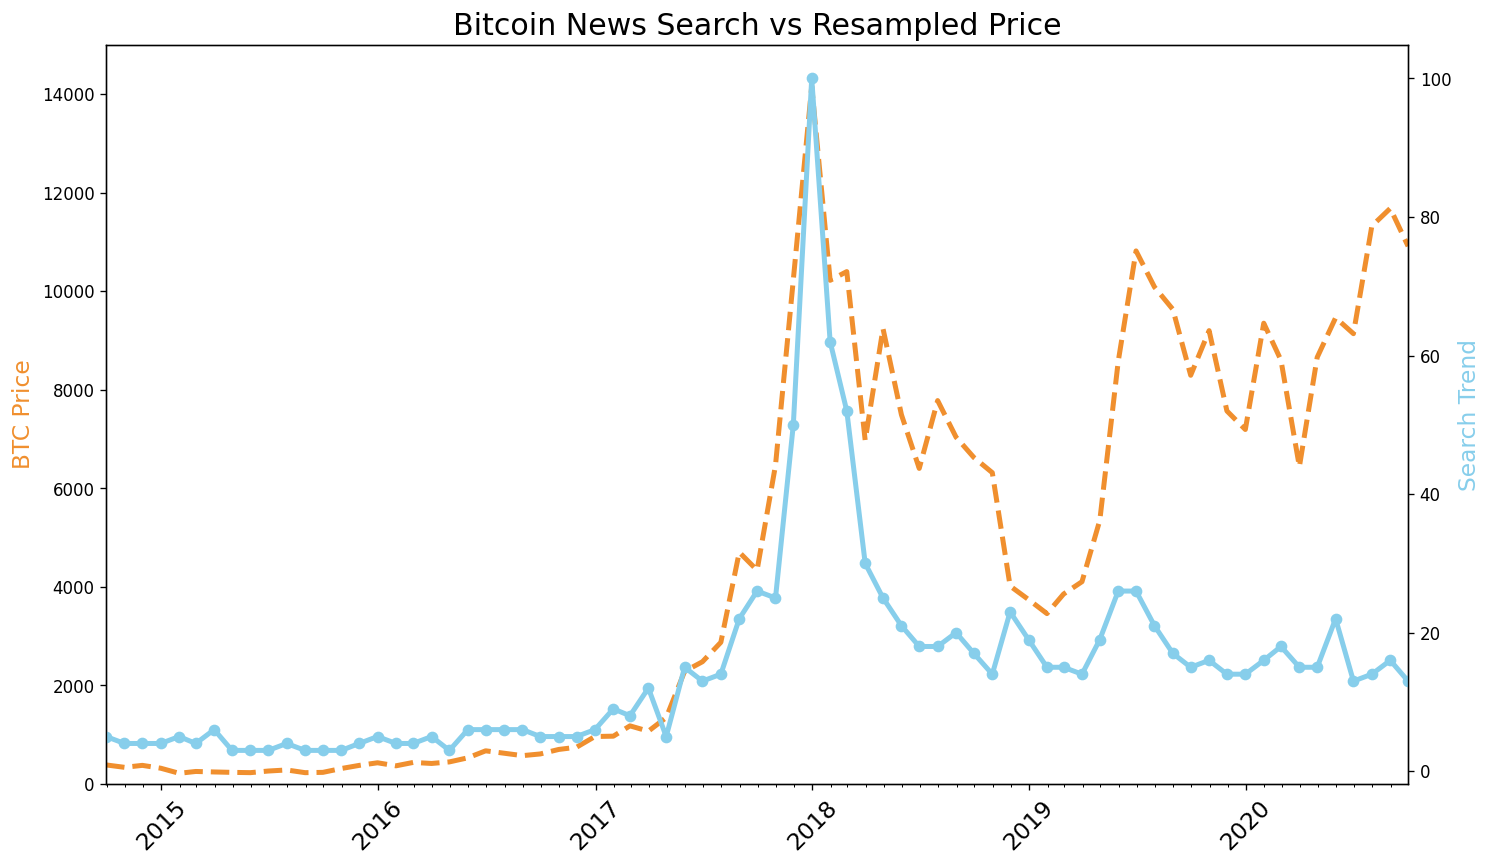

In [6]:
# Create locators for ticks on the time axis
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')
# Register date converters to avoid warning messages
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(14,8), dpi=120)

plt.title('Bitcoin News Search vs Resampled Price', fontsize=18)
plt.xticks(fontsize=14, rotation=45)

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.set_ylabel('BTC Price', color='#F08F2E', fontsize=14)
ax2.set_ylabel('Search Trend', color='skyblue', fontsize=14)

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)

ax1.set_ylim(bottom=0, top=15000)
ax1.set_xlim([df_btc_monthly.index.min(), df_btc_monthly.index.max()])

# Experiment with the linestyle and markers
ax1.plot(df_btc_monthly.index, df_btc_monthly.CLOSE, 
         color='#F08F2E', linewidth=3, linestyle='--')
ax2.plot(df_btc_monthly.index, df_btc_search.BTC_NEWS_SEARCH, 
         color='skyblue', linewidth=3, marker='o')

plt.show()

In [7]:
df_btc_search['MONTH'] = pd.to_datetime(df_btc_search['MONTH'])
df_btc_search.set_index('MONTH', inplace=True)
df_btc_search

BTC_NEWS_SEARCH
MONTH                      
2014-09-01                5
2014-10-01                4
2014-11-01                4
2014-12-01                4
2015-01-01                5
...                     ...
2020-05-01               22
2020-06-01               13
2020-07-01               14
2020-08-01               16
2020-09-01               13

[73 rows x 1 columns]

In [8]:
df_btc_price['DATE'] = pd.to_datetime(df_btc_price['DATE'])
df_btc_price.set_index('DATE', inplace=True)
df_btc_price

CLOSE        VOLUME
DATE                                  
2014-09-17    457.334015  2.105680e+07
2014-09-18    424.440002  3.448320e+07
2014-09-19    394.795990  3.791970e+07
2014-09-20    408.903992  3.686360e+07
2014-09-21    398.821014  2.658010e+07
...                  ...           ...
2020-09-24  10745.548828  2.301754e+10
2020-09-25  10702.290039  2.123255e+10
2020-09-26  10754.437500  1.810501e+10
2020-09-27  10774.426758  1.801688e+10
2020-09-28  10912.536133  2.122653e+10

[2203 rows x 2 columns]

In [9]:
df_combined = pd.merge(df_btc_price, df_btc_search, left_index=True, right_index=True, how='inner')
df_combined

CLOSE        VOLUME  BTC_NEWS_SEARCH
2014-10-01    383.614990  2.622940e+07                4
2014-11-01    325.748993  1.667720e+07                4
2014-12-01    379.244995  1.176300e+07                4
2015-01-01    314.248993  8.036550e+06                5
2015-02-01    226.972000  2.912850e+07                4
...                  ...           ...              ...
2020-05-01   8864.766602  4.406839e+10               22
2020-06-01  10167.268555  3.519890e+10               13
2020-07-01   9228.325195  1.597155e+10               14
2020-08-01  11759.592773  2.607567e+10               16
2020-09-01  11970.478516  2.731156e+10               13

[72 rows x 3 columns]

Correlation coefficient: 0.6395240100522647


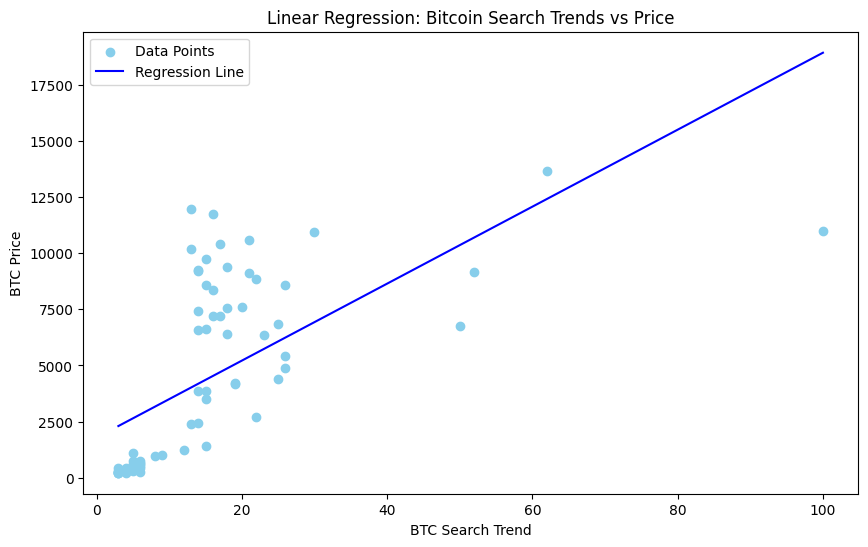

In [12]:
from scipy.stats import pearsonr

# Calculate the correlation coefficient
correlation = pearsonr(df_combined['CLOSE'], df_combined['BTC_NEWS_SEARCH'])
print("Correlation coefficient:", correlation[0])

# Check how many data points are available after merging
if len(df_combined) > 1:
    # Prepare data for regression
    x = df_combined['BTC_NEWS_SEARCH'].values.reshape(-1, 1)
    y = df_combined['CLOSE'].values

    # Fit model
    model = LinearRegression().fit(x, y)

    # Calculate the regression line
    x_range = np.linspace(x.min(), x.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='skyblue', label='Data Points')  # Scatter plot of the data points
    plt.plot(x_range, y_range, color='blue', label='Regression Line')  # Regression line
    plt.title('Linear Regression: Bitcoin Search Trends vs Price')
    plt.xlabel('BTC Search Trend')
    plt.ylabel('BTC Price')
    plt.legend()
    plt.show()
else:
    print("Insufficient data points to perform regression analysis.")

# Sentiment

In [166]:
news_2023_df = pd.read_csv('data/ADA_df/2023_cryptonews.csv')
# Creating the desired DataFrame format
df = news_2023_df[['date', 'title', 'text']].rename(columns={'title': 'headline', 'text': 'description'})

df.to_csv('data/ADA_df/testing_news_data.csv', index=False)

df

date                                           headline  \
0      2023-12-19 06:40:41  Grayscale CEO Calls for Simultaneous Approval ...   
1      2023-12-19 06:03:24  Indian Government is Actively Collaborating Wi...   
2      2023-12-19 05:55:14  Judge Approves Settlement: Binance to Pay $1.5...   
3      2023-12-19 05:35:26  Why a gold rush for inscriptions has broken ha...   
4      2023-12-19 05:31:08  ‘Concerning precedent’ — bloXroute Labs' MEV r...   
...                    ...                                                ...   
31032  2021-10-27 15:17:00  Cream Finance Suffers Another Exploit as Attac...   
31033  2021-10-19 13:39:00  French Central Bank's Blockchain Bond Trial Br...   
31034  2021-10-18 13:58:00  Facebook To Add 10,000 Jobs In EU For Metavers...   
31035  2021-10-15 00:00:00  Tech Crackdown Hasn't Halted Chinese Firms' Bl...   
31036  2021-10-12 20:00:00  Celo to Be Fastest EVM Chain by End of 2022, C...   

                                             description  
0      Grayscale CEO Michael Sonnenshein believes the...  
1      In an exclusive interview with CryptoNews, Man...  
2      According to the Federal Court ruling on Decem...  
3      Some suggest EVM inscriptions are the latest w...  
4      A decision by bloXroute Labs to start censorin...  
...                                                  ...  
31032  Cream Finance (CREAM) suffered another flash l...  
31033  Banque de France disclosed the results of its ...  
31034  Advancing its project to become \x9caÂ\xa0meta...  
31035  Chinese companies are still topping the blockc...  
31036  Within a little more than a year, Celo aims to...  

[31037 rows x 3 columns]

In [13]:
price_data = pd.read_csv('data/ADA_df/Binance_BTCUSDT_1h (1).csv')
price_data['Date'] = price_data['Date'].str.split('.').str[0]
# Convert 'Date' column to datetime
price_data['Date'] = pd.to_datetime(price_data['Date'])
# Convert datetime to Unix timestamp
price_data['timestamp'] = price_data['Date'].apply(lambda x: int(datetime.timestamp(x)))
# Select and rename columns
price_data = price_data[['Symbol', 'timestamp', 'Close']]
price_data.columns = ['coin name', 'timestamp', 'price']
price_data.to_csv('data/ADA_df/testing_price_data.csv', index=False)
price_data.head()


coin name   timestamp     price
0   BTCUSDT  1697749200  28713.71
1   BTCUSDT  1697745600  28649.65
2   BTCUSDT  1697742000  28604.09
3   BTCUSDT  1697738400  28715.38
4   BTCUSDT  1697734800  28750.75

In [7]:
analyzer = SentimentAnalyzer()
sentiment_data = analyzer.add_sentiments_to_df(df)
sentiment_data.head()
df.to_csv('data/ADA_df/testing_news_with_sentiment_data.csv', index=False)

In [17]:
sentiment_data = pd.read_csv(f"data/ADA_df/testing_news_with_sentiment_data.csv")
sentiment_data

date                                           headline  \
0      2023-12-19 06:40:41  Grayscale CEO Calls for Simultaneous Approval ...   
1      2023-12-19 06:03:24  Indian Government is Actively Collaborating Wi...   
2      2023-12-19 05:55:14  Judge Approves Settlement: Binance to Pay $1.5...   
3      2023-12-19 05:35:26  Why a gold rush for inscriptions has broken ha...   
4      2023-12-19 05:31:08  ‘Concerning precedent’ — bloXroute Labs' MEV r...   
...                    ...                                                ...   
31032  2021-10-27 15:17:00  Cream Finance Suffers Another Exploit as Attac...   
31033  2021-10-19 13:39:00  French Central Bank's Blockchain Bond Trial Br...   
31034  2021-10-18 13:58:00  Facebook To Add 10,000 Jobs In EU For Metavers...   
31035  2021-10-15 00:00:00  Tech Crackdown Hasn't Halted Chinese Firms' Bl...   
31036  2021-10-12 20:00:00  Celo to Be Fastest EVM Chain by End of 2022, C...   

                                             description  sentiment  
0      Grayscale CEO Michael Sonnenshein believes the...   0.109364  
1      In an exclusive interview with CryptoNews, Man...   0.169890  
2      According to the Federal Court ruling on Decem...   0.011100  
3      Some suggest EVM inscriptions are the latest w...   0.013950  
4      A decision by bloXroute Labs to start censorin...   0.014481  
...                                                  ...        ...  
31032  Cream Finance (CREAM) suffered another flash l...   0.008009  
31033  Banque de France disclosed the results of its ...   0.226058  
31034  Advancing its project to become \x9caÂ\xa0meta...   0.873976  
31035  Chinese companies are still topping the blockc...   0.921093  
31036  Within a little more than a year, Celo aims to...   0.869037  

[31037 rows x 4 columns]

## August 2023

In [14]:
price_data = pd.read_csv(f"../data/ADA_df/testing_price_data.csv")
from_date = 0
end = hd.get_date_str(265)
start = hd.get_date_str(294)
print(start, end)
# Convert the start and end dates to Unix timestamps
start_timestamp = int(pd.Timestamp(start).timestamp())
end_timestamp = int(pd.Timestamp(end).timestamp())

# Filter the data for the specified date range
price_data = price_data[(price_data['timestamp'] >= start_timestamp) & (price_data['timestamp'] <= end_timestamp)]

2023-08-03 2023-09-01


In [15]:
# Calculate the raw price changes and check for large variations
price_data['raw_change'] = price_data['price'].diff()
print(price_data[['price', 'raw_change']].describe())


              price   raw_change
count    697.000000   696.000000
mean   27804.117690     4.480402
std     1540.897337   111.153109
min    25669.290000 -1440.030000
25%    26087.150000   -26.735000
50%    28394.340000    -0.255000
75%    29303.840000    32.030000
max    30076.320000  1425.650000


Incorrect date format found in rows:
                      date                                           headline  \
30606    2022-01-12 00:00  Republic of Palau and Cryptic Labs launch digi...   
30619    2022-01-11 00:00  Ethereum futures and options data reflects tra...   
30693  2021-12-9 21:00:00  Lack of Transparency Blighting El Salvador's B...   
30694  2021-12-9 18:16:00  Polygon Makes USD 400M Bet On Ethereum Scaling...   
30695  2021-12-9 17:34:00  Bitcoin Hashrate Close to Full Recovery After ...   
...                   ...                                                ...   
30888  2021-11-3 11:36:00  Ethereum Name Service to Pass Governance Over ...   
30889  2021-11-3 10:41:00  Ethereum Futures ETF May Come Before Spot Bitc...   
30945  2021-11-2 19:00:00  CryptoPunk Mistakenly Sells at Over 99% Discou...   
30946  2021-11-2 15:07:00  SCRT Rallies As Quentin Tarantino Releases NFT...   
31030  2021-11-1 15:18:00  Google's Parent Increases its Crypto Bet by Jo...   

 

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d %H:%M:%S")


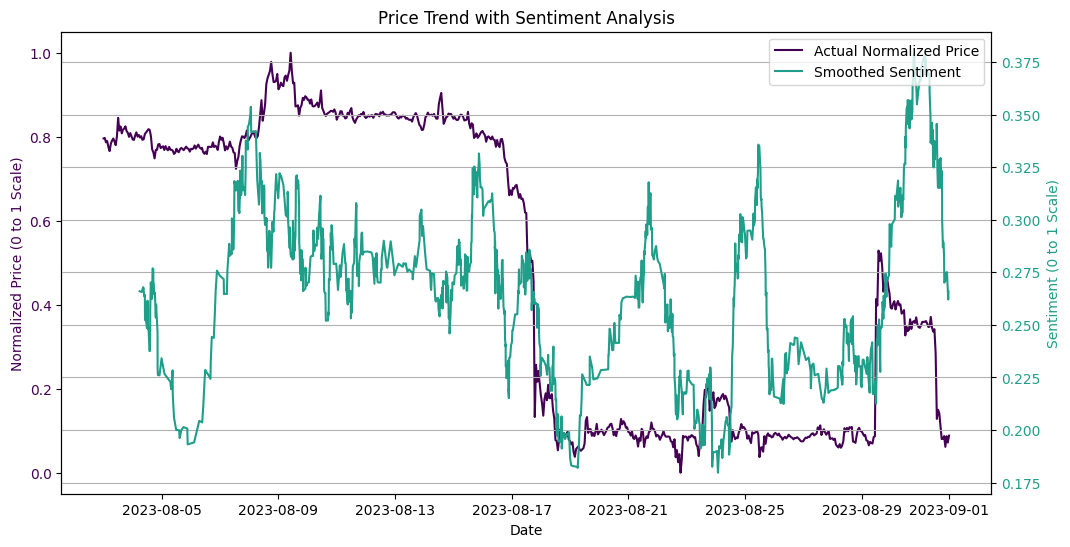

In [18]:
vz.window_size = 70
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data, end, start)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)

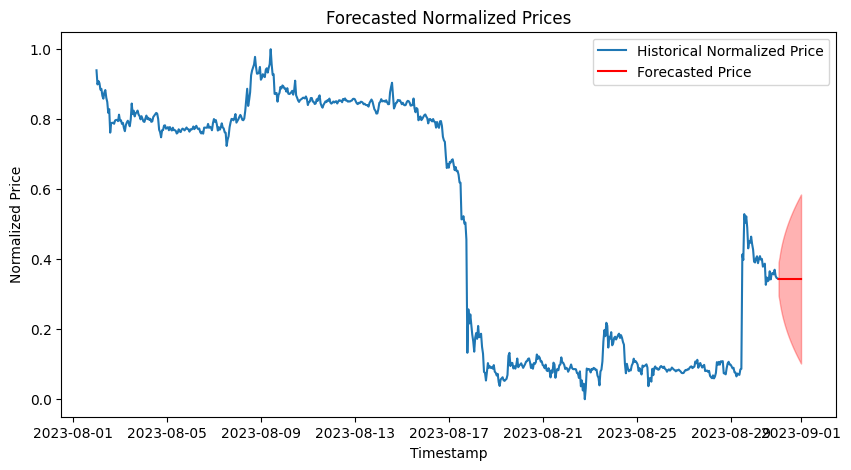

{'average_change_percent': -0.4609723459305224,
 'average_ci_lower_percent': -47.94984176910466,
 'average_ci_upper_percent': 47.027897077243615,
 'rmse': 0.042966877809816055}

In [64]:
averages_forecasts, plot = vz.forecast_prices_with_arima(price_data, forecast_periods=24, for_web=False)
averages_forecasts

In [40]:
sentiment_data

average sentiment
date                                  
2023-09-01 00:21:24           0.012299
2023-09-01 00:38:09           0.079867
2023-09-01 00:39:00           0.903820
2023-09-01 00:59:00           0.018746
2023-09-01 01:00:00           0.840943
...                                ...
2023-09-29 20:47:00           0.043253
2023-09-29 21:50:00           0.027652
2023-09-29 22:02:00           0.025685
2023-09-29 22:37:00           0.791002
2023-09-29 22:40:00           0.129326

[1416 rows x 1 columns]

In [14]:
# Check for any unusual spikes in normalized price data
print(price_data.describe())
# Count how many normalized prices are exactly zero
zero_count = (price_data['normalized price'] == 0).sum()
print(f"Count of zero values in normalized price: {zero_count}")


       normalized price
count        697.000000
mean           0.489570
std            0.346149
min            0.010000
25%            0.103869
50%            0.622158
75%            0.826469
max            1.000000
Count of zero values in normalized price: 0


In [15]:
# Resample sentiment data to hourly frequency, taking the mean sentiment for each hour
sentiment_data_hourly = sentiment_data.resample('D').mean()
price_data_daily = price_data.resample('D').mean()  # Consider changing this if alignment issues are suspected

# Merge the datasets on the hourly timestamp
combined_data = pd.merge(
    price_data,
    sentiment_data_hourly,
    left_index=True,
    right_index=True,
    how='inner'
)


epsilon = 0.01  # Adjust this value based on the minimum expected non-zero price
combined_data['Next Day Price Change'] = (
    (combined_data['normalized price'].shift(-1) - combined_data['normalized price']) /
    (combined_data['normalized price'] + epsilon)
) * 100

combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_data.dropna(inplace=True)
combined_data

normalized price  average sentiment  Next Day Price Change
2023-08-03          0.797971           0.267124              -0.305278
2023-08-04          0.795505           0.205073              -2.229665
2023-08-05          0.777545           0.165183              -0.498318
2023-08-06          0.773620           0.473657               3.681427
2023-08-07          0.802469           0.309304              -0.662475
2023-08-08          0.797086           0.312008              14.449810
2023-08-09          0.913709           0.278044              -2.672467
2023-08-10          0.889023           0.266776              -5.229332
2023-08-11          0.842010           0.295483               0.486189
2023-08-12          0.846152           0.250217               1.439179
2023-08-13          0.858474           0.309835              -3.267417
2023-08-14          0.830097           0.252775               1.711086
2023-08-15          0.844472           0.320816              -3.387210
2023-08-16          0.815529           0.243522             -18.253381
2023-08-17          0.664842           0.231410             -69.978575
2023-08-18          0.192597           0.203133             -53.236000
2023-08-19          0.084743           0.270762              21.811453
2023-08-20          0.105407           0.421187               0.657919
2023-08-21          0.106167           0.240792              -6.143631
2023-08-22          0.099030           0.227853              -4.365913
2023-08-23          0.094270           0.194910              71.113270
2023-08-24          0.168419           0.288474             -30.663240
2023-08-25          0.113710           0.231653              -9.978193
2023-08-26          0.101366           0.275053             -15.320194
2023-08-27          0.084305           0.257404               7.251056
2023-08-28          0.091143           0.205786              16.477845
2023-08-29          0.107809           0.311466             247.100233
2023-08-30          0.398914           0.359120             -11.566769

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:195: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


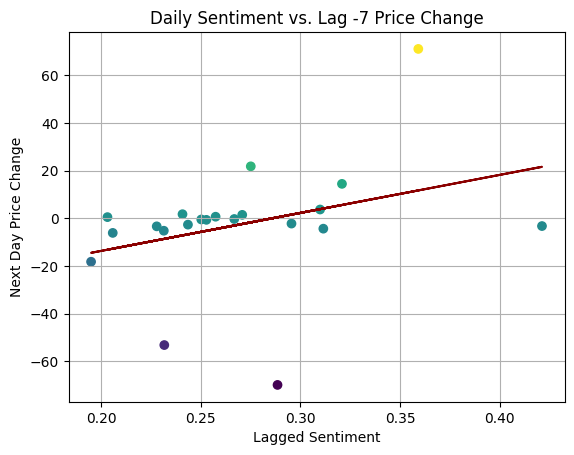

Correlation with -7 Day(s) lag: 0.33
Linear Model R-squared: 0.13
Linear Model RMSE: 20.05

Average Price Change on High Sentiment Days: 308 %
Average Price Change on Low Sentiment Days: -779 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:195: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


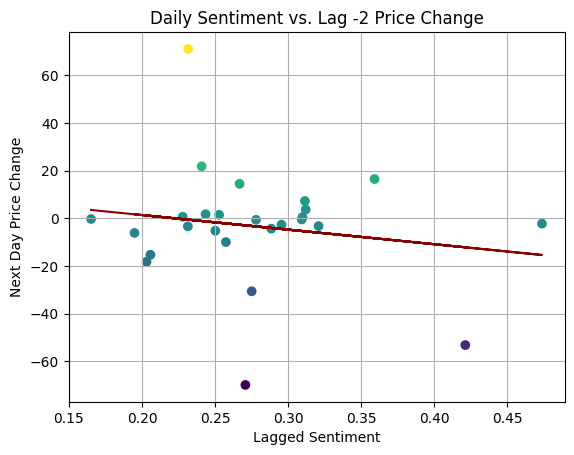

Correlation with -2 Day(s) lag: -0.17
Linear Model R-squared: -0.48
Linear Model RMSE: 13.3

Average Price Change on High Sentiment Days: -157 %
Average Price Change on Low Sentiment Days: -513 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:195: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


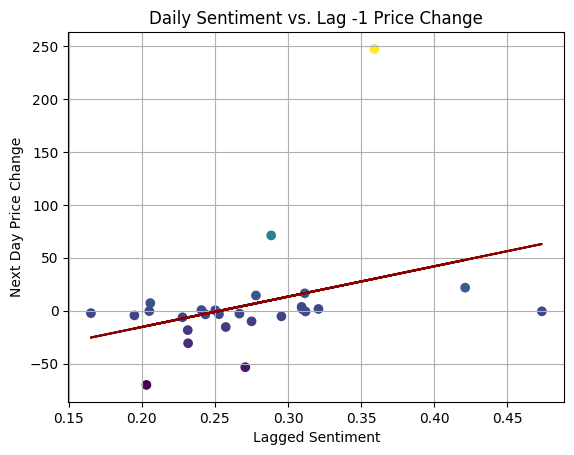

Correlation with -1 Day(s) lag: 0.36
Linear Model R-squared: -1.14
Linear Model RMSE: 22.61

Average Price Change on High Sentiment Days: 1784 %
Average Price Change on Low Sentiment Days: -514 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:195: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


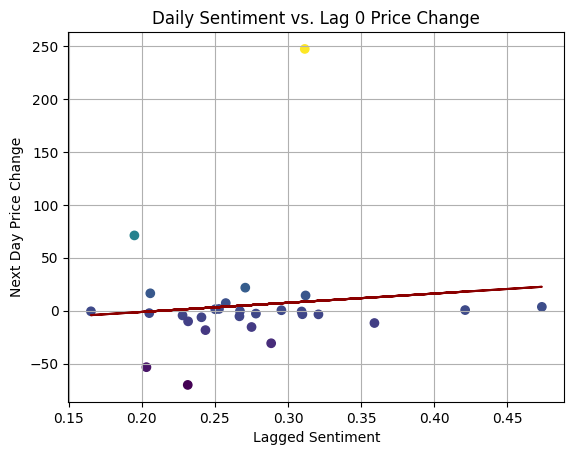

Correlation with 0 Day(s) lag: 0.11
Linear Model R-squared: -1.93
Linear Model RMSE: 22.35

Average Price Change on High Sentiment Days: 1574 %
Average Price Change on Low Sentiment Days: -514 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:195: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


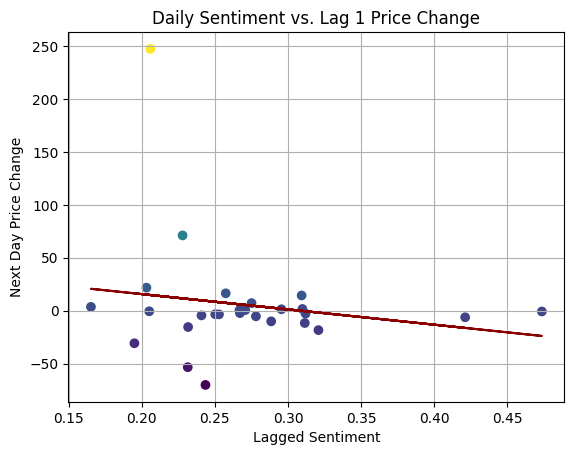

Correlation with 1 Day(s) lag: -0.17
Linear Model R-squared: -1.26
Linear Model RMSE: 35.71

Average Price Change on High Sentiment Days: 1697 %
Average Price Change on Low Sentiment Days: -514 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:195: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


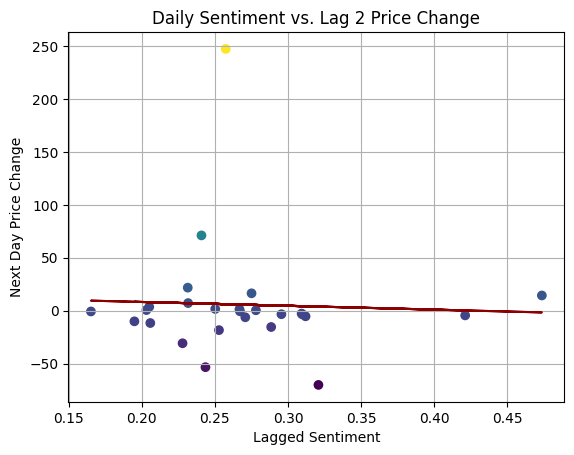

Correlation with 2 Day(s) lag: -0.04
Linear Model R-squared: -0.07
Linear Model RMSE: 95.98

Average Price Change on High Sentiment Days: 1697 %
Average Price Change on Low Sentiment Days: -536 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:195: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


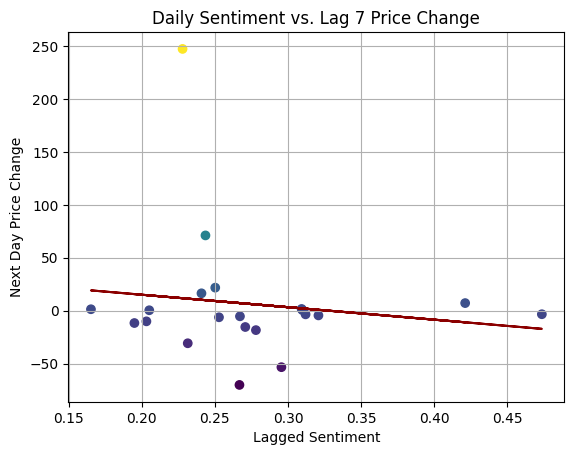

Correlation with 7 Day(s) lag: -0.14
Linear Model R-squared: -1.76
Linear Model RMSE: 32.79

Average Price Change on High Sentiment Days: 2006 %
Average Price Change on Low Sentiment Days: -581 %


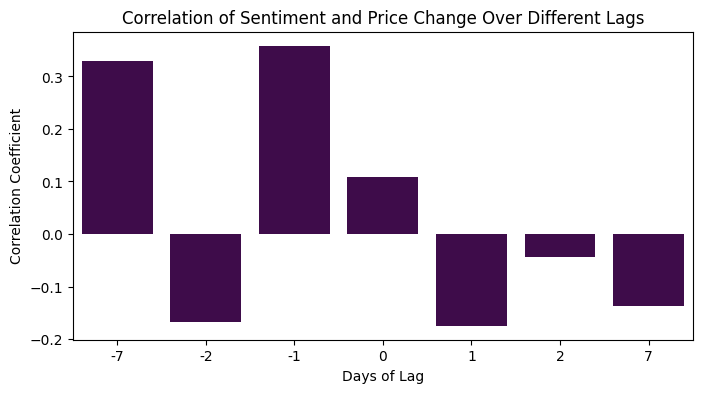

In [16]:
# Perform Analysis
from_date=30
model_type = 'linear'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:204: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


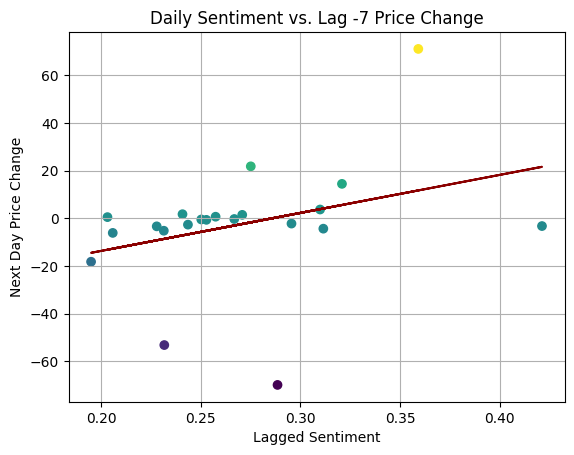

Correlation with -7 Day(s) lag: 0.33
Rf Model R-squared: -0.69
Rf Model RMSE: 27.99

Average Price Change on High Sentiment Days: 308 %
Average Price Change on Low Sentiment Days: -779 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:204: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


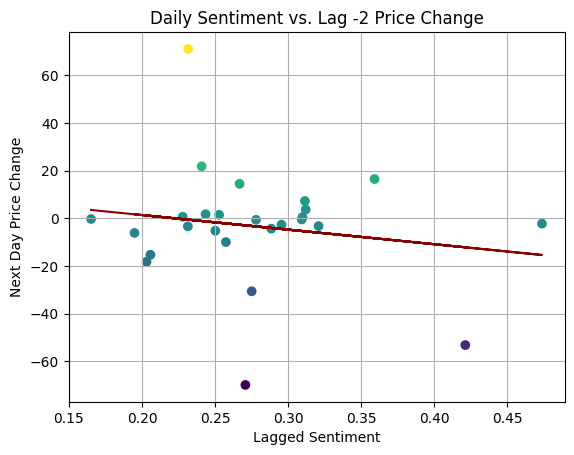

Correlation with -2 Day(s) lag: -0.17
Rf Model R-squared: 0.07
Rf Model RMSE: 10.55

Average Price Change on High Sentiment Days: -157 %
Average Price Change on Low Sentiment Days: -513 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:204: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


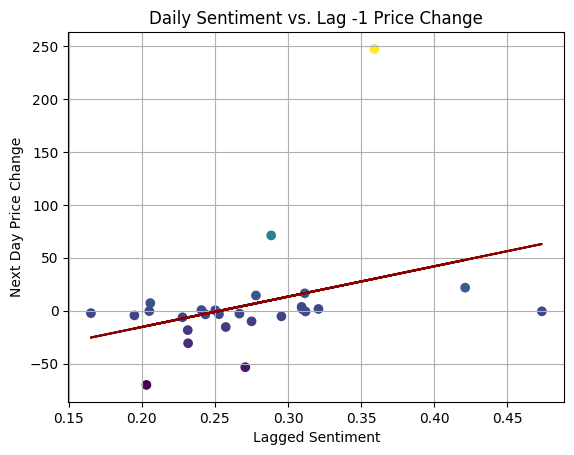

Correlation with -1 Day(s) lag: 0.36
Rf Model R-squared: -0.28
Rf Model RMSE: 17.52

Average Price Change on High Sentiment Days: 1784 %
Average Price Change on Low Sentiment Days: -514 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:204: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


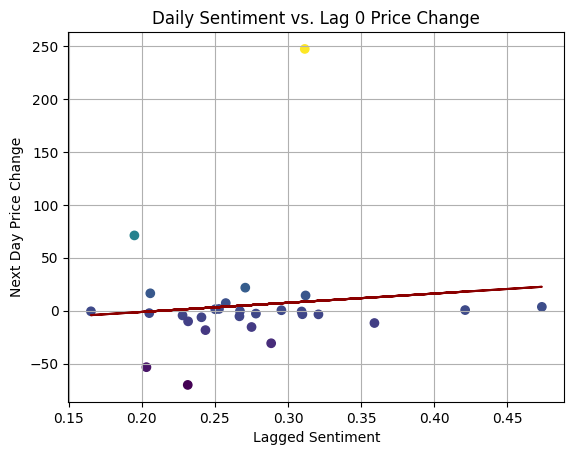

Correlation with 0 Day(s) lag: 0.11
Rf Model R-squared: -4.34
Rf Model RMSE: 30.16

Average Price Change on High Sentiment Days: 1574 %
Average Price Change on Low Sentiment Days: -514 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:204: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


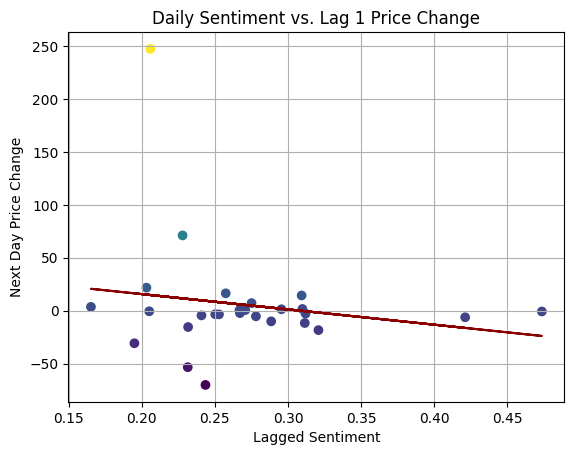

Correlation with 1 Day(s) lag: -0.17
Rf Model R-squared: -0.04
Rf Model RMSE: 24.22

Average Price Change on High Sentiment Days: 1697 %
Average Price Change on Low Sentiment Days: -514 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:204: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


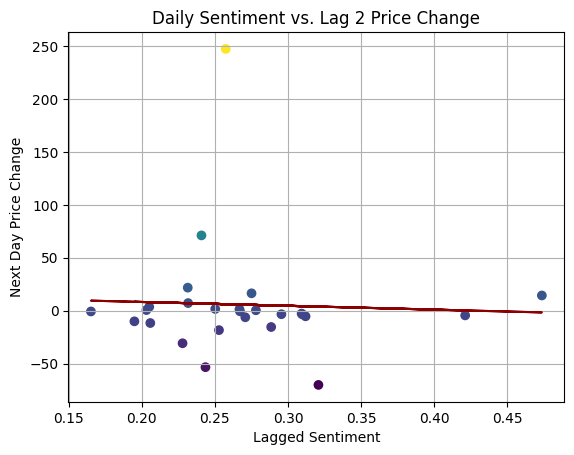

Correlation with 2 Day(s) lag: -0.04
Rf Model R-squared: -0.14
Rf Model RMSE: 98.98

Average Price Change on High Sentiment Days: 1697 %
Average Price Change on Low Sentiment Days: -536 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:204: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


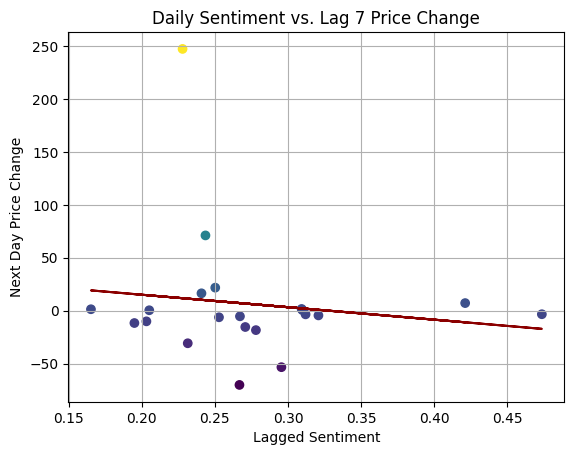

Correlation with 7 Day(s) lag: -0.14
Rf Model R-squared: -3.66
Rf Model RMSE: 42.65

Average Price Change on High Sentiment Days: 2006 %
Average Price Change on Low Sentiment Days: -581 %


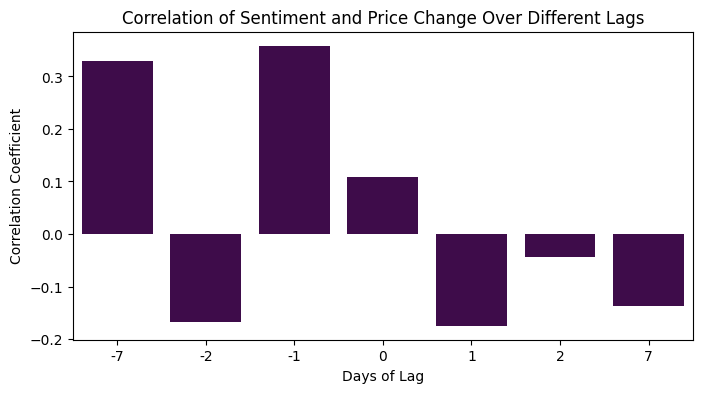

In [17]:
# Perform Analysis
from_date=30
model_type = 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

## Meme Doge

In [104]:
price_data = pd.read_csv('data/ADA_df/Binance_DOGEUSDT_1h (1).csv')
price_data['Date'] = price_data['Date'].str.split('.').str[0]
# Convert 'Date' column to datetime
price_data['Date'] = pd.to_datetime(price_data['Date'])
# Convert datetime to Unix timestamp
price_data['timestamp'] = price_data['Date'].apply(lambda x: int(datetime.timestamp(x)))
# Select and rename columns
price_data = price_data[['Symbol', 'timestamp', 'Close']]
price_data.columns = ['coin name', 'timestamp', 'price']
price_data.to_csv('data/ADA_df/testing_price_data_doge.csv', index=False)
price_data.head()

coin name   timestamp    price
0  DOGEUSDT  1697749200  0.05887
1  DOGEUSDT  1697745600  0.05865
2  DOGEUSDT  1697742000  0.05858
3  DOGEUSDT  1697738400  0.05872
4  DOGEUSDT  1697734800  0.05867

2023-08-03 2023-09-01
      coin name   timestamp     price
0      DOGEUSDT  1697749200  0.058870
1      DOGEUSDT  1697745600  0.058650
2      DOGEUSDT  1697742000  0.058580
3      DOGEUSDT  1697738400  0.058720
4      DOGEUSDT  1697734800  0.058670
...         ...         ...       ...
37571  DOGEUSDT  1562335200  0.003666
37572  DOGEUSDT  1562331600  0.003738
37573  DOGEUSDT  1562328000  0.003841
37574  DOGEUSDT  1562324400  0.003835
37575  DOGEUSDT  1562320800  0.003925

[37576 rows x 3 columns]
Incorrect date format found in rows:
                      date                                           headline  \
30606    2022-01-12 00:00  Republic of Palau and Cryptic Labs launch digi...   
30619    2022-01-11 00:00  Ethereum futures and options data reflects tra...   
30693  2021-12-9 21:00:00  Lack of Transparency Blighting El Salvador's B...   
30694  2021-12-9 18:16:00  Polygon Makes USD 400M Bet On Ethereum Scaling...   
30695  2021-12-9 17:34:00  Bitcoin Hashrate Close to Full 

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d %H:%M:%S")


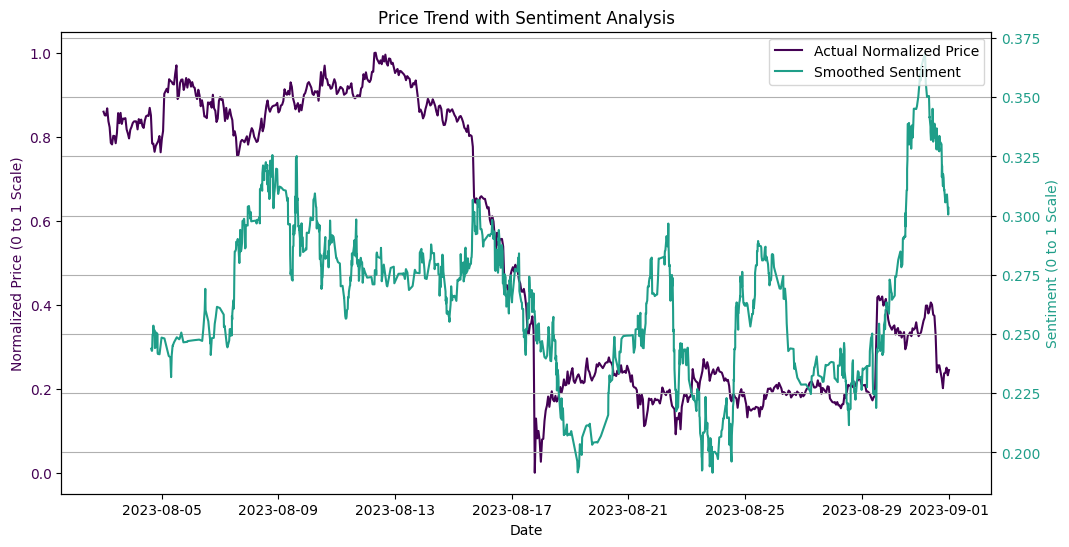

In [105]:
price_data = pd.read_csv(f"data/ADA_df/testing_price_data_doge.csv")
sentiment_data = pd.read_csv(f"data/ADA_df/testing_news_with_sentiment_data.csv")
from_date = 0
end = hd.get_date_str(265)
start = hd.get_date_str(294)
print(start, end)
# Convert the start and end dates to Unix timestamps
start_timestamp = int(pd.Timestamp(start).timestamp())
end_timestamp = int(pd.Timestamp(end).timestamp())
vz.window_size = 100
# Filter the data for the specified date range
print(price_data)
price_data = price_data[(price_data['timestamp'] >= start_timestamp) & (price_data['timestamp'] <= end_timestamp)]
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data, end, start)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


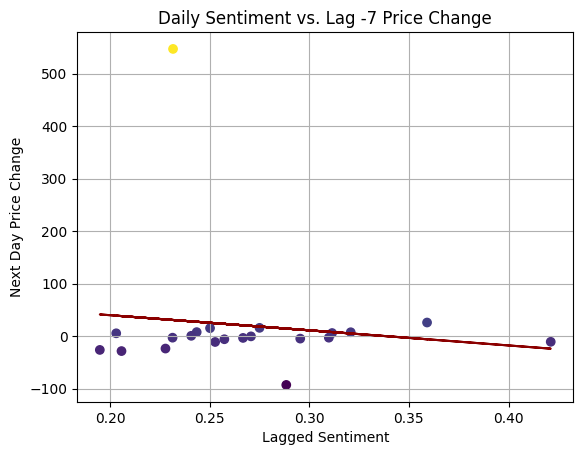

Correlation with -7 Day(s) lag: -0.13
Linear Model R-squared: -0.25
Linear Model RMSE: 228.36

Average Price Change on High Sentiment Days: -189 %
Average Price Change on Low Sentiment Days: 4017 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


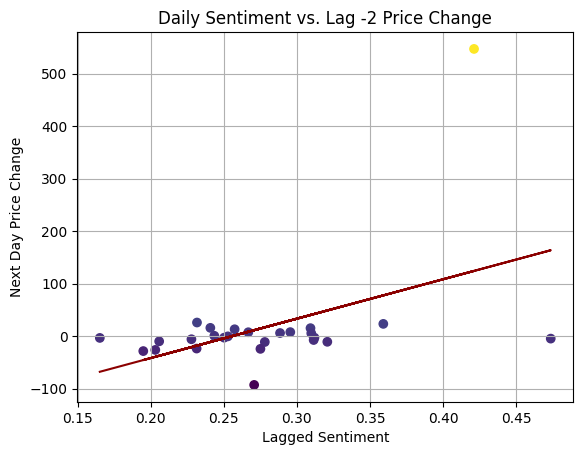

Correlation with -2 Day(s) lag: 0.46
Linear Model R-squared: -12.36
Linear Model RMSE: 43.67

Average Price Change on High Sentiment Days: -425 %
Average Price Change on Low Sentiment Days: 3649 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


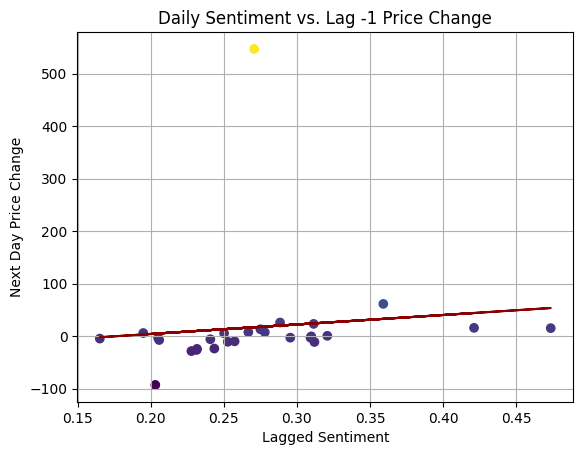

Correlation with -1 Day(s) lag: 0.11
Linear Model R-squared: -4.72
Linear Model RMSE: 34.02

Average Price Change on High Sentiment Days: 70 %
Average Price Change on Low Sentiment Days: 3369 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


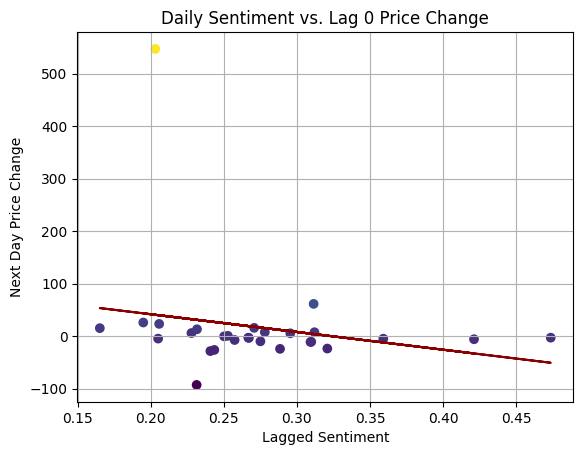

Correlation with 0 Day(s) lag: -0.21
Linear Model R-squared: -2.31
Linear Model RMSE: 27.92

Average Price Change on High Sentiment Days: 32 %
Average Price Change on Low Sentiment Days: 3369 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


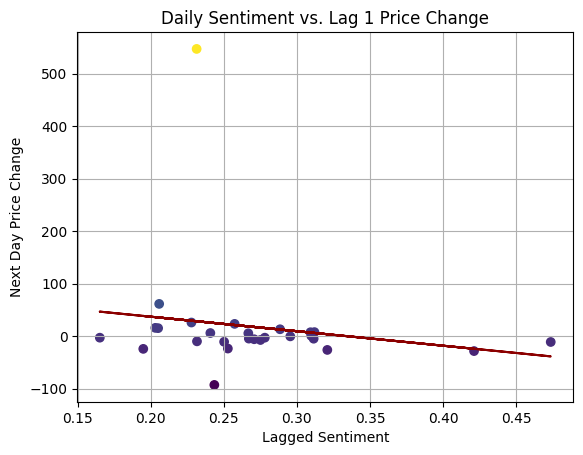

Correlation with 1 Day(s) lag: -0.17
Linear Model R-squared: -2.64
Linear Model RMSE: 61.56

Average Price Change on High Sentiment Days: 59 %
Average Price Change on Low Sentiment Days: 3369 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


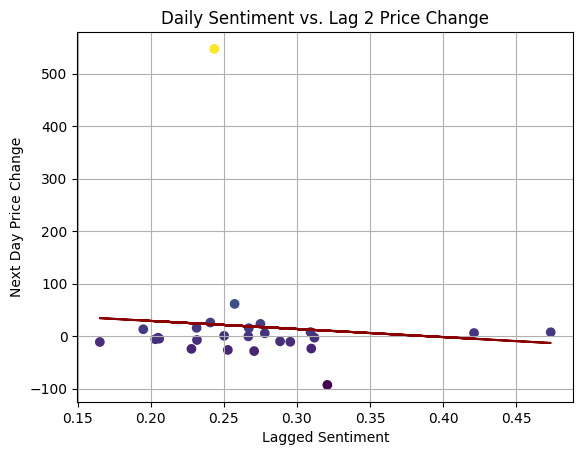

Correlation with 2 Day(s) lag: -0.09
Linear Model R-squared: -0.19
Linear Model RMSE: 210.16

Average Price Change on High Sentiment Days: 59 %
Average Price Change on Low Sentiment Days: 3662 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


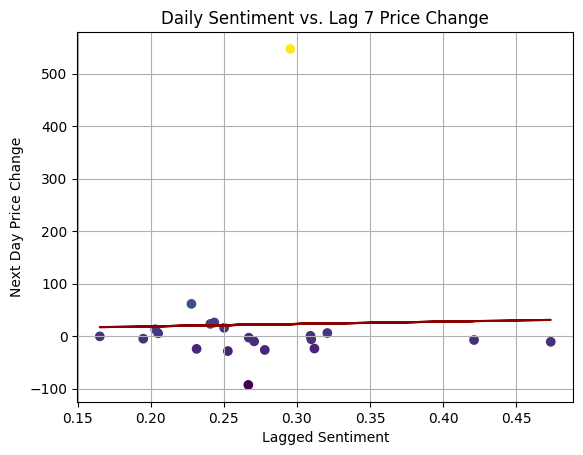

Correlation with 7 Day(s) lag: 0.03
Linear Model R-squared: -0.21
Linear Model RMSE: 226.14

Average Price Change on High Sentiment Days: 29 %
Average Price Change on Low Sentiment Days: 4212 %


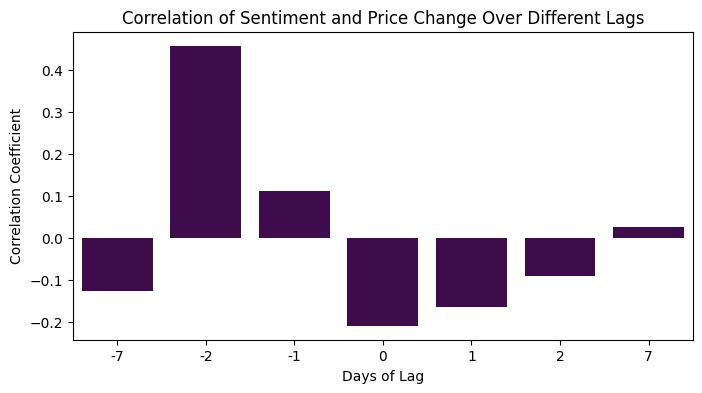

In [106]:
# Resample sentiment data to hourly frequency, taking the mean sentiment for each hour
sentiment_data_hourly = sentiment_data.resample('D').mean()
price_data_daily = price_data.resample('D').mean()  # Consider changing this if alignment issues are suspected

# Merge the datasets on the hourly timestamp
combined_data = pd.merge(
    price_data,
    sentiment_data_hourly,
    left_index=True,
    right_index=True,
    how='inner'
)


epsilon = 0.01  # Adjust this value based on the minimum expected non-zero price
combined_data['Next Day Price Change'] = (
    (combined_data['normalized price'].shift(-1) - combined_data['normalized price']) /
    (combined_data['normalized price'] + epsilon)
) * 100

combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_data.dropna(inplace=True)
combined_data
# Perform Analysis
from_date=30
model_type = 'linear'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:205: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


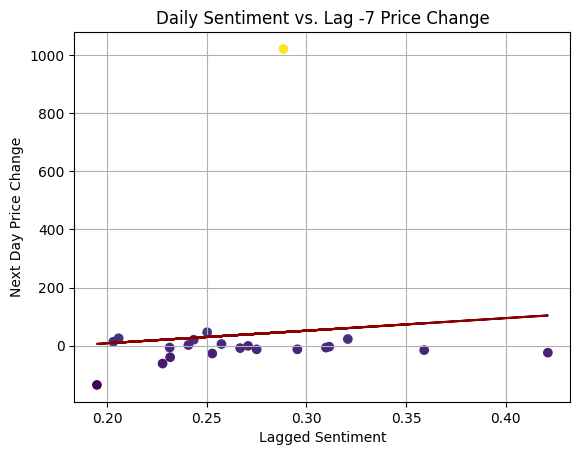

Correlation with -7 Day(s) lag: 0.1
Rf Model R-squared: -183.86
Rf Model RMSE: 276.62

Average Price Change on High Sentiment Days: -754 %
Average Price Change on Low Sentiment Days: 8039 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:205: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


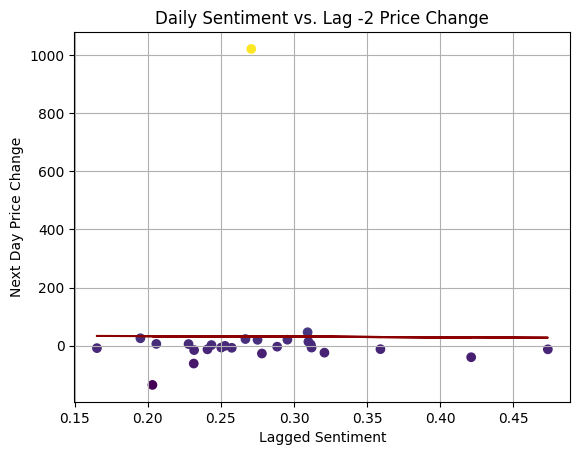

Correlation with -2 Day(s) lag: -0.01
Rf Model R-squared: -0.38
Rf Model RMSE: 56.07

Average Price Change on High Sentiment Days: -423 %
Average Price Change on Low Sentiment Days: 6735 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:205: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


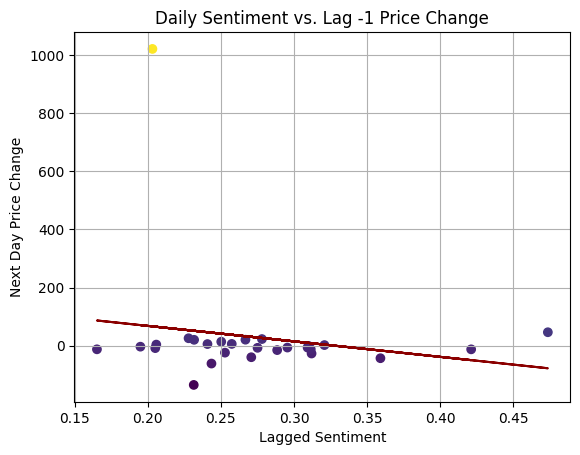

Correlation with -1 Day(s) lag: -0.18
Rf Model R-squared: -4.2
Rf Model RMSE: 112.33

Average Price Change on High Sentiment Days: -705 %
Average Price Change on Low Sentiment Days: 6210 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:205: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


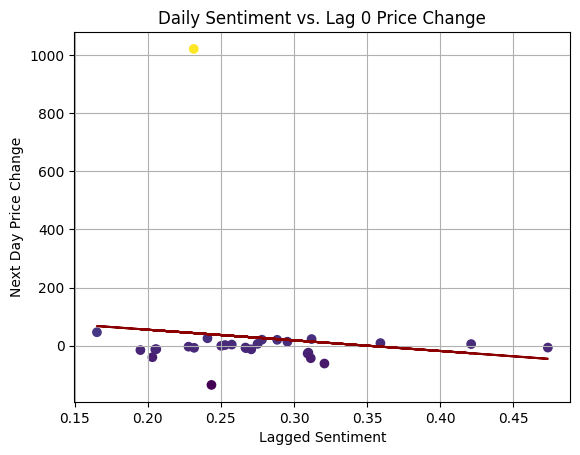

Correlation with 0 Day(s) lag: -0.12
Rf Model R-squared: -0.59
Rf Model RMSE: 31.44

Average Price Change on High Sentiment Days: -590 %
Average Price Change on Low Sentiment Days: 6210 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:205: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


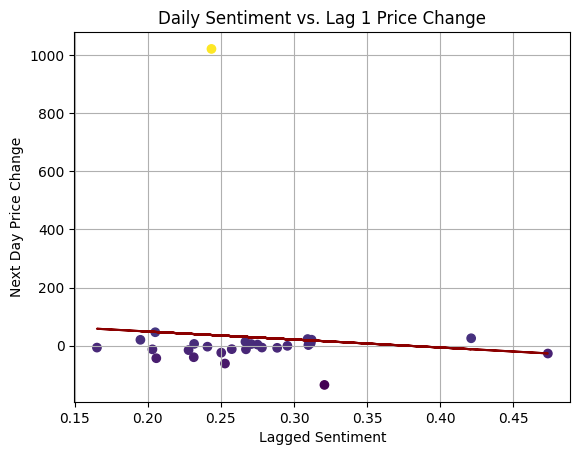

Correlation with 1 Day(s) lag: -0.09
Rf Model R-squared: -0.14
Rf Model RMSE: 388.3

Average Price Change on High Sentiment Days: -572 %
Average Price Change on Low Sentiment Days: 6210 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:205: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


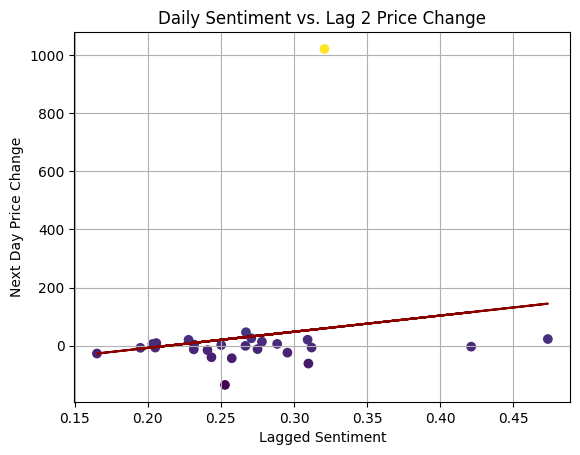

Correlation with 2 Day(s) lag: 0.18
Rf Model R-squared: -0.06
Rf Model RMSE: 56.28

Average Price Change on High Sentiment Days: -572 %
Average Price Change on Low Sentiment Days: 6782 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:205: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


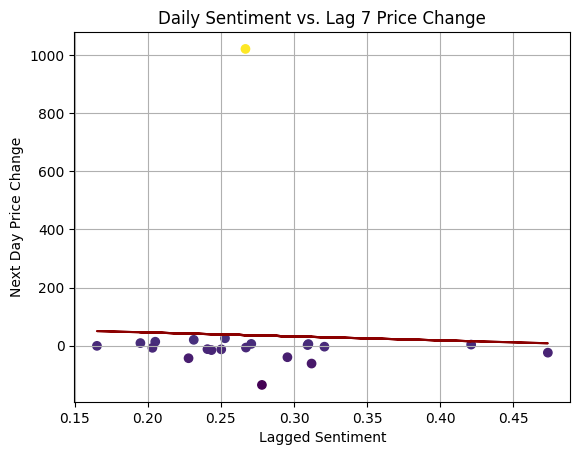

Correlation with 7 Day(s) lag: -0.04
Rf Model R-squared: -106.22
Rf Model RMSE: 269.48

Average Price Change on High Sentiment Days: -913 %
Average Price Change on Low Sentiment Days: 7649 %


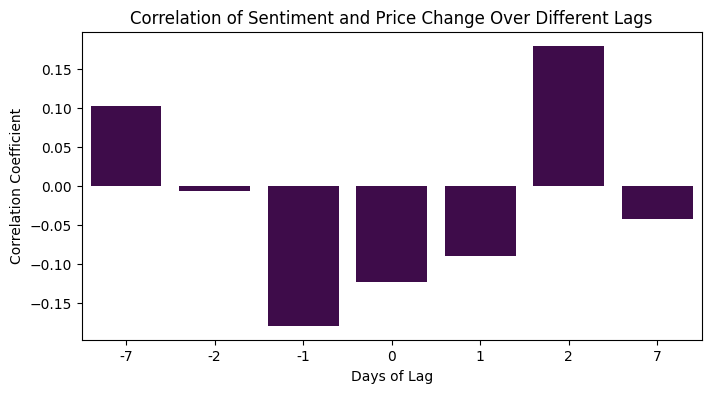

In [27]:
# Perform Analysis
from_date=30
model_type = 'rf'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

## Large Time Scale

2021-10-12 20:00:00 2023-12-19 06:40:41
2022-01-14 2023-10-16
Incorrect date format found in rows:
                      date                                           headline  \
30606    2022-01-12 00:00  Republic of Palau and Cryptic Labs launch digi...   
30619    2022-01-11 00:00  Ethereum futures and options data reflects tra...   
30693  2021-12-9 21:00:00  Lack of Transparency Blighting El Salvador's B...   
30694  2021-12-9 18:16:00  Polygon Makes USD 400M Bet On Ethereum Scaling...   
30695  2021-12-9 17:34:00  Bitcoin Hashrate Close to Full Recovery After ...   
...                   ...                                                ...   
30888  2021-11-3 11:36:00  Ethereum Name Service to Pass Governance Over ...   
30889  2021-11-3 10:41:00  Ethereum Futures ETF May Come Before Spot Bitc...   
30945  2021-11-2 19:00:00  CryptoPunk Mistakenly Sells at Over 99% Discou...   
30946  2021-11-2 15:07:00  SCRT Rallies As Quentin Tarantino Releases NFT...   
31030  2021-11-1 15:

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d %H:%M:%S")


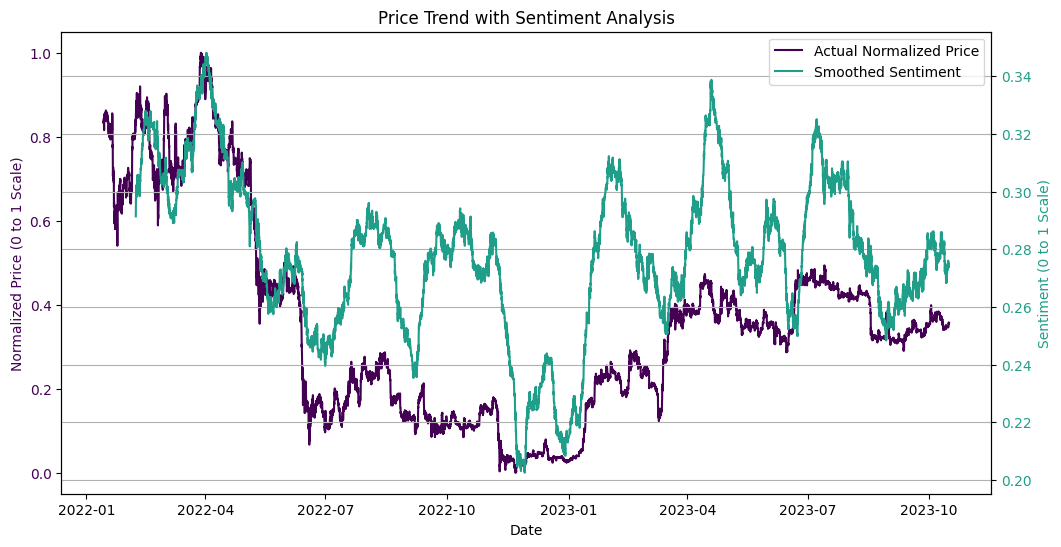

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


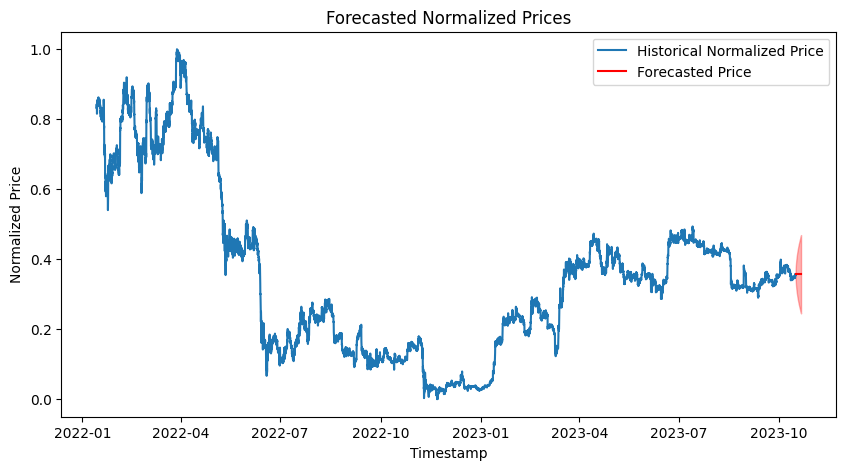

{'average_change_percent': 0.0,
 'average_ci_lower_percent': -21.02298972303639,
 'average_ci_upper_percent': 21.02298972303639,
 'rmse': 0.008507884803665567}

In [113]:
# Load the sentiment data and price data
sentiment_data_path = 'data/ADA_df/testing_news_with_sentiment_data.csv'
sentiment_data = pd.read_csv(sentiment_data_path)
print(sentiment_data['date'].min(),sentiment_data['date'].max())
price_data = pd.read_csv(f"data/ADA_df/testing_price_data.csv")
from_date = 0
end = hd.get_date_str(220)
start = hd.get_date_str(860)
print(start, end)
# Convert the start and end dates to Unix timestamps
start_timestamp = int(pd.Timestamp(start).timestamp())
end_timestamp = int(pd.Timestamp(end).timestamp())
# Filter the data for the specified date range
price_data = price_data[(price_data['timestamp'] >= start_timestamp) & (price_data['timestamp'] <= end_timestamp)]

vz.window_size = 800
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data, end, start)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)
averages_forecasts, plot = vz.forecast_prices_with_arima(price_data, forecast_periods=120, for_web=False)
averages_forecasts

In [116]:
# Get the closing price for each day (last price of the day)
price_data_daily = price_data['normalized price'].resample('D').last()

# Calculate the daily price change percentage
price_data_daily = pd.DataFrame(price_data_daily)  # Ensure it's a DataFrame for the next operations
price_data_daily['Price Change'] = price_data_daily['normalized price'].pct_change() * 100

# Shift the price change to align with the day's sentiment to measure its influence on the next day's price change
price_data_daily['Price Change'] = price_data_daily['Price Change'].shift(-1)

# Since sentiment is often recorded multiple times a day, we'll average it for daily granularity
sentiment_data_daily = pd.DataFrame(sentiment_data['average sentiment'].resample('D').mean())

# Merge the two datasets on the date index
combined_data = pd.concat([price_data_daily, sentiment_data_daily], axis=1)
combined_data.columns = ['Normalized Price', 'Next Day Price Change', 'average sentiment']
combined_data.dropna(inplace=True)  # Drop rows with NaN values that might result from resampling, shifting, or non-overlapping dates

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


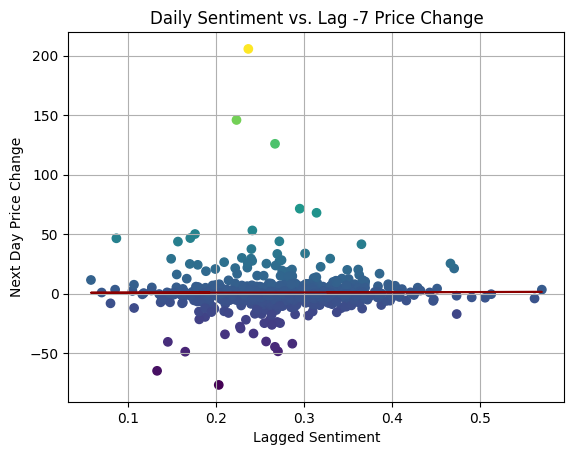

Correlation with -7 Day(s) lag: 0.01
Linear Model R-squared: -0.01
Linear Model RMSE: 25.94

Average Price Change on High Sentiment Days: 60 %
Average Price Change on Low Sentiment Days: 138 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


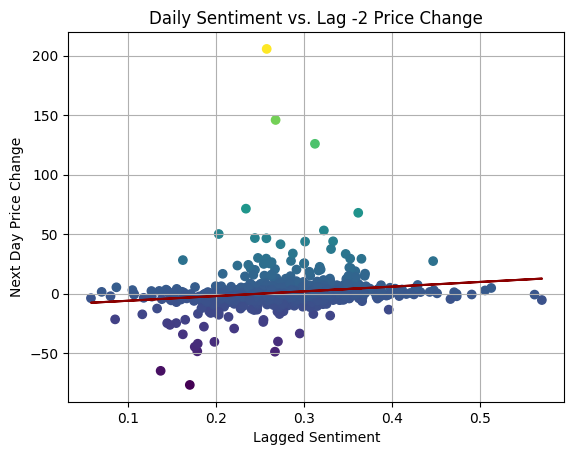

Correlation with -2 Day(s) lag: 0.17
Linear Model R-squared: 0.0
Linear Model RMSE: 21.06

Average Price Change on High Sentiment Days: 64 %
Average Price Change on Low Sentiment Days: 131 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


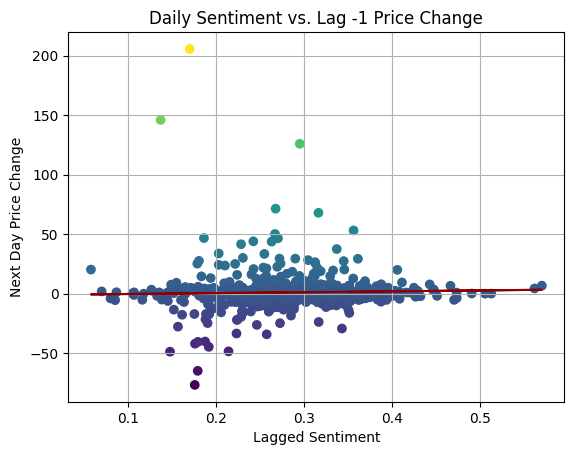

Correlation with -1 Day(s) lag: 0.03
Linear Model R-squared: 0.0
Linear Model RMSE: 16.92

Average Price Change on High Sentiment Days: 61 %
Average Price Change on Low Sentiment Days: 135 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


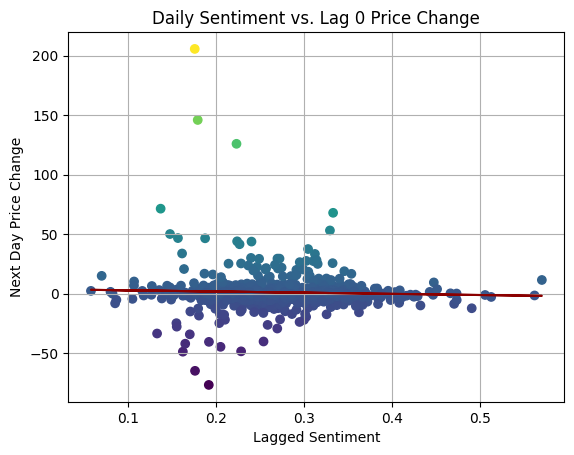

Correlation with 0 Day(s) lag: -0.04
Linear Model R-squared: -0.0
Linear Model RMSE: 20.92

Average Price Change on High Sentiment Days: 60 %
Average Price Change on Low Sentiment Days: 135 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


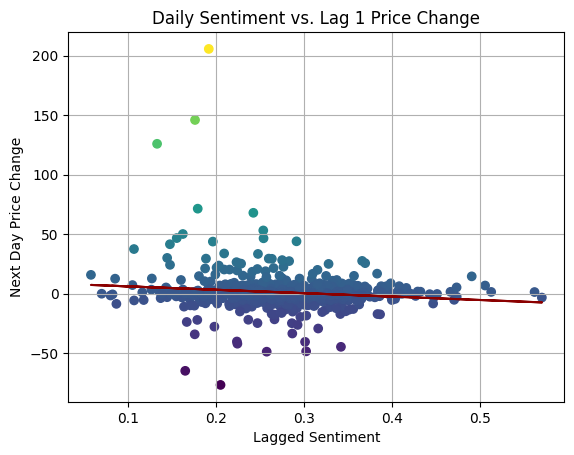

Correlation with 1 Day(s) lag: -0.12
Linear Model R-squared: 0.04
Linear Model RMSE: 13.08

Average Price Change on High Sentiment Days: 60 %
Average Price Change on Low Sentiment Days: 136 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


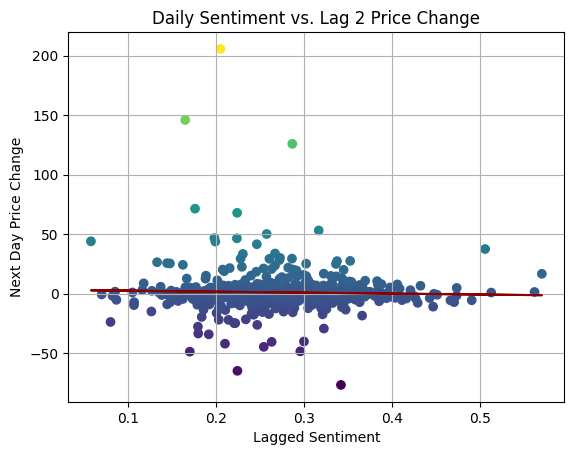

Correlation with 2 Day(s) lag: -0.03
Linear Model R-squared: -0.04
Linear Model RMSE: 9.93

Average Price Change on High Sentiment Days: 61 %
Average Price Change on Low Sentiment Days: 135 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


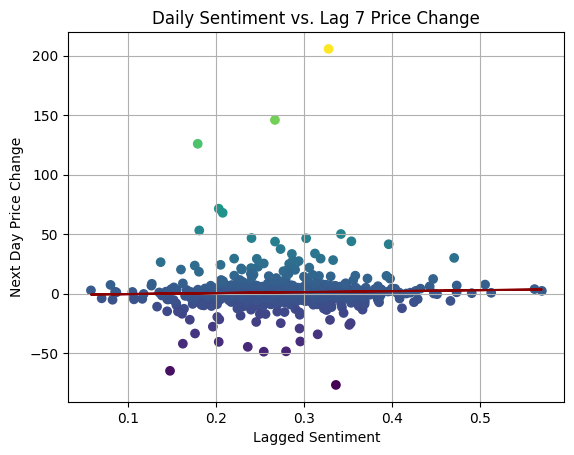

Correlation with 7 Day(s) lag: 0.04
Linear Model R-squared: -0.0
Linear Model RMSE: 23.62

Average Price Change on High Sentiment Days: 73 %
Average Price Change on Low Sentiment Days: 132 %


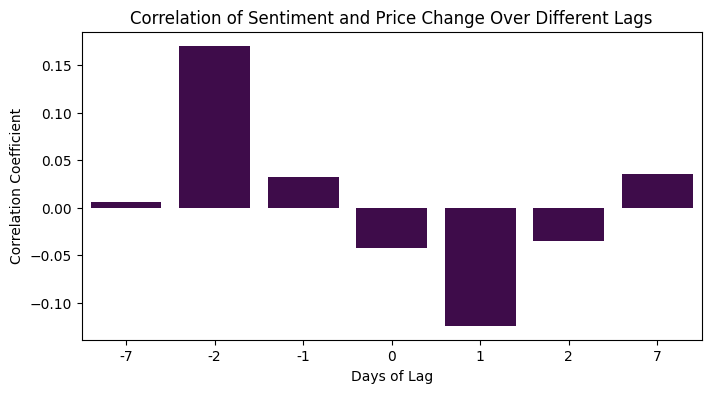

In [117]:
# Perform Analysis
from_date = 30
model_type = 'linear'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


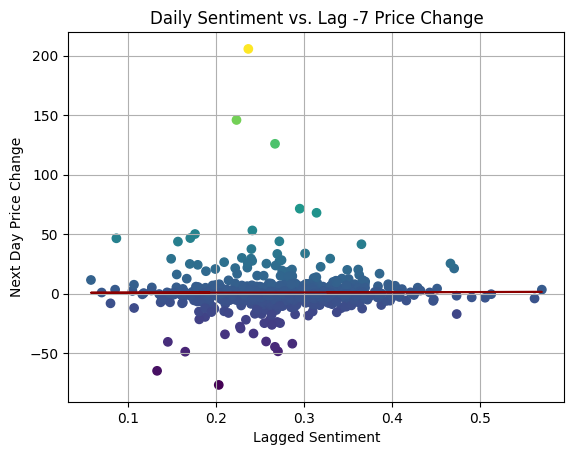

Correlation with -7 Day(s) lag: 0.01
Rf Model R-squared: -0.13
Rf Model RMSE: 27.45

Average Price Change on High Sentiment Days: 60 %
Average Price Change on Low Sentiment Days: 138 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


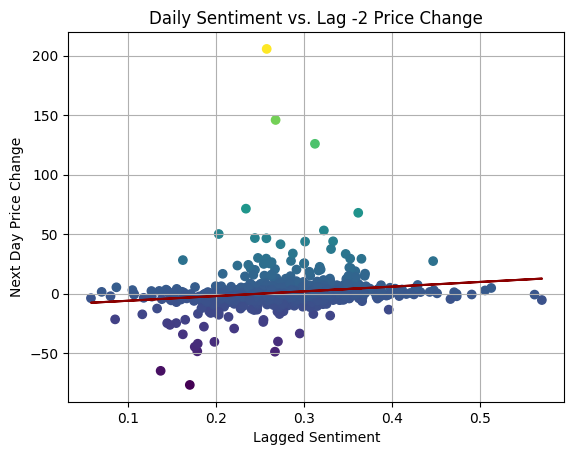

Correlation with -2 Day(s) lag: 0.17
Rf Model R-squared: -0.2
Rf Model RMSE: 23.1

Average Price Change on High Sentiment Days: 64 %
Average Price Change on Low Sentiment Days: 131 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


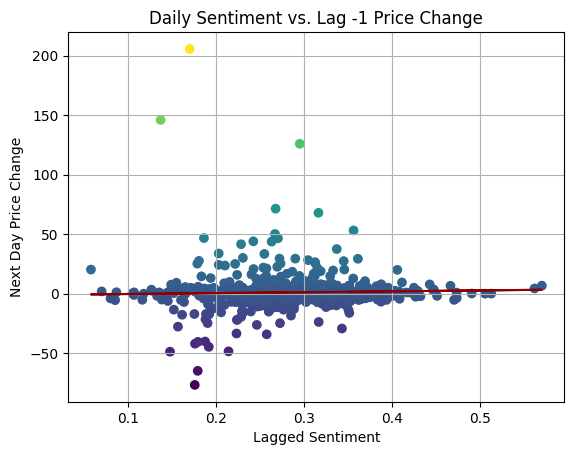

Correlation with -1 Day(s) lag: 0.03
Rf Model R-squared: -0.25
Rf Model RMSE: 18.92

Average Price Change on High Sentiment Days: 61 %
Average Price Change on Low Sentiment Days: 135 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


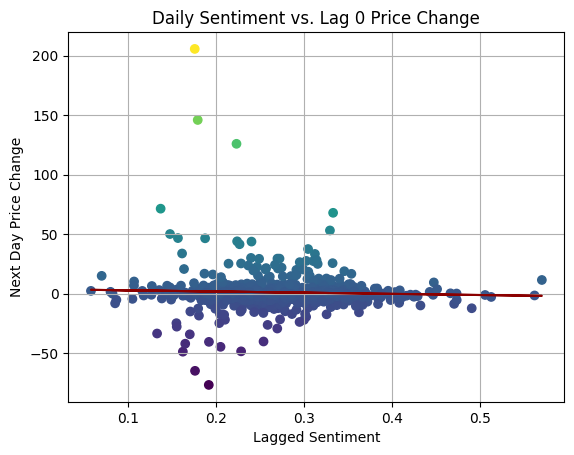

Correlation with 0 Day(s) lag: -0.04
Rf Model R-squared: -0.29
Rf Model RMSE: 23.75

Average Price Change on High Sentiment Days: 60 %
Average Price Change on Low Sentiment Days: 135 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


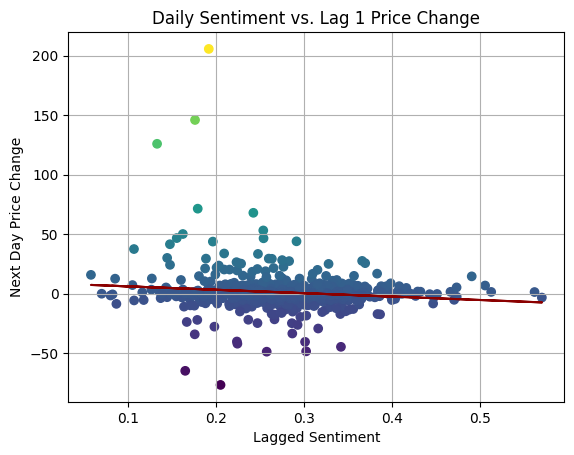

Correlation with 1 Day(s) lag: -0.12
Rf Model R-squared: -1.81
Rf Model RMSE: 22.31

Average Price Change on High Sentiment Days: 60 %
Average Price Change on Low Sentiment Days: 136 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


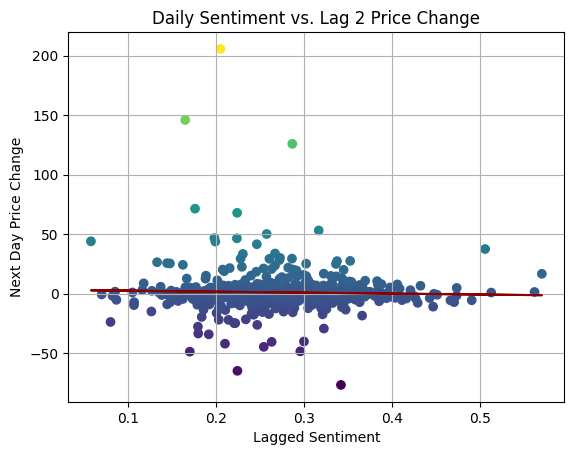

Correlation with 2 Day(s) lag: -0.03
Rf Model R-squared: -4.1
Rf Model RMSE: 22.03

Average Price Change on High Sentiment Days: 61 %
Average Price Change on Low Sentiment Days: 135 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


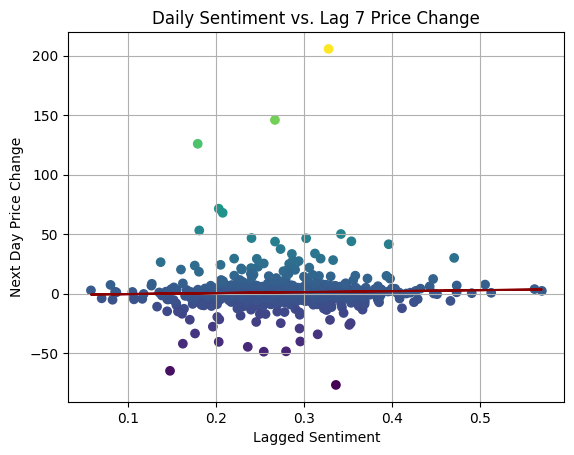

Correlation with 7 Day(s) lag: 0.04
Rf Model R-squared: -0.2
Rf Model RMSE: 25.81

Average Price Change on High Sentiment Days: 73 %
Average Price Change on Low Sentiment Days: 132 %


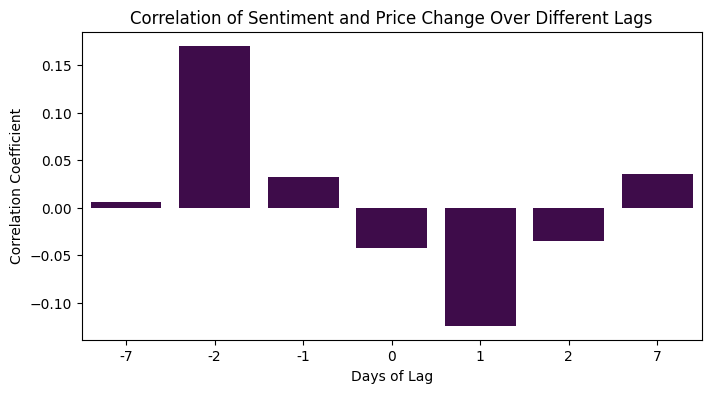

In [118]:

model_type = 'rf'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

# Monthly Time Scale APIs Data

2024-04-18 00:00:00 2024-05-21 00:00:00


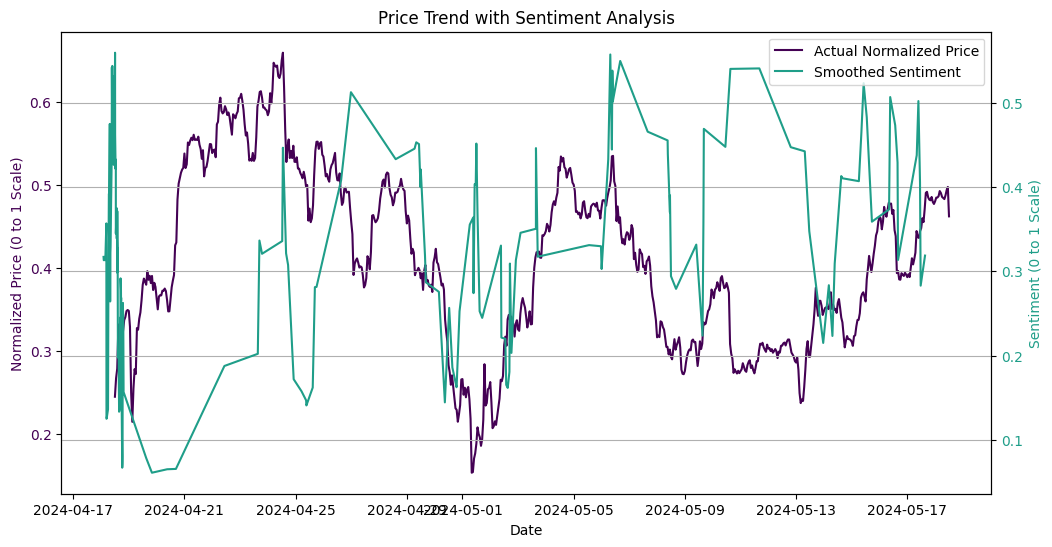

In [107]:
#for testing purposes
sentiment_data = pd.read_csv(f"data/2024-05-18_30d_news_with_sentiment.csv")
price_data = pd.read_csv('data/2024-05-18_30d_50meme_history.csv')
from_date = 0
end = hd.get_date_dt(2)
start = hd.get_date_dt(35)
print(start, end)
# Convert the start and end dates to Unix timestamps
start_timestamp = int(pd.Timestamp(start).timestamp())
end_timestamp = int(pd.Timestamp(end).timestamp())
vz.window_size = 7
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data, end=end, start=start)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)

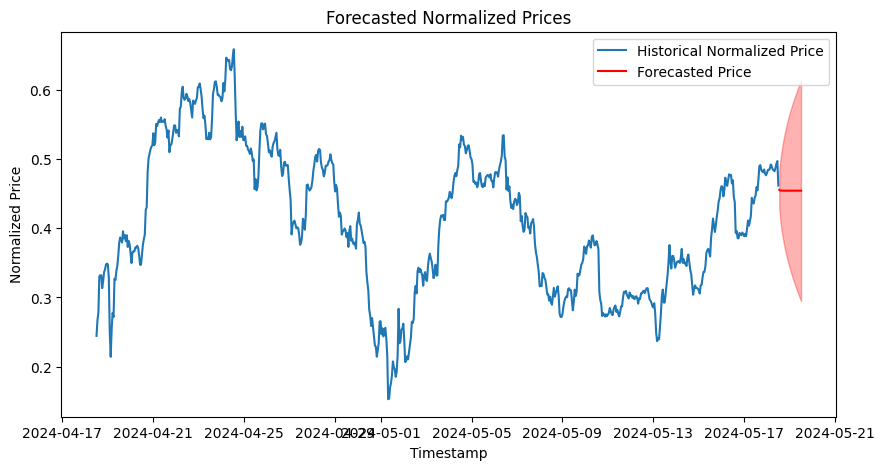

{'average_change_percent': -1.5810704835553206,
 'average_ci_lower_percent': -24.99198130192875,
 'average_ci_upper_percent': 21.829840334818112,
 'rmse': 0.0165921610958595}

In [108]:
averages_forecasts, plot = vz.forecast_prices_with_arima(price_data, forecast_periods=24, for_web=False)
averages_forecasts

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


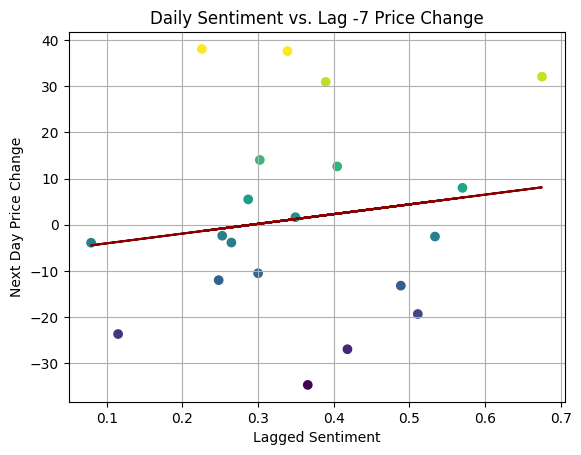

Correlation with -7 Day(s) lag: 0.15
Linear Model R-squared: -0.22
Linear Model RMSE: 28.08

Average Price Change on High Sentiment Days: -580 %
Average Price Change on Low Sentiment Days: 851 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


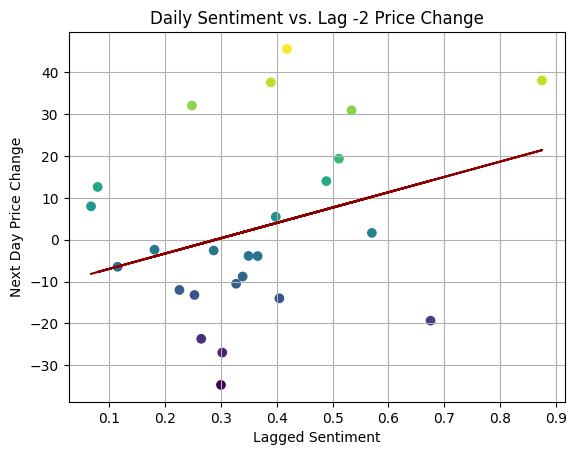

Correlation with -2 Day(s) lag: 0.31
Linear Model R-squared: -0.27
Linear Model RMSE: 29.99

Average Price Change on High Sentiment Days: -220 %
Average Price Change on Low Sentiment Days: 686 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


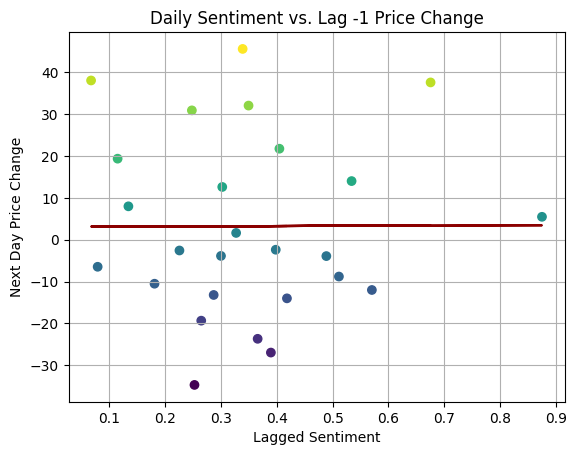

Correlation with -1 Day(s) lag: 0.0
Linear Model R-squared: -0.26
Linear Model RMSE: 23.76

Average Price Change on High Sentiment Days: -35 %
Average Price Change on Low Sentiment Days: 686 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


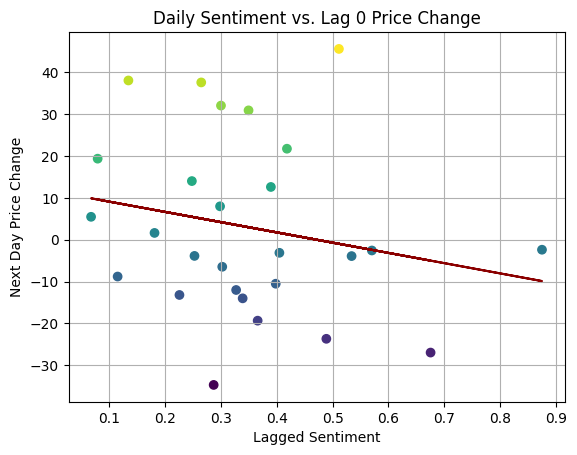

Correlation with 0 Day(s) lag: -0.21
Linear Model R-squared: -0.01
Linear Model RMSE: 22.24

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 551 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


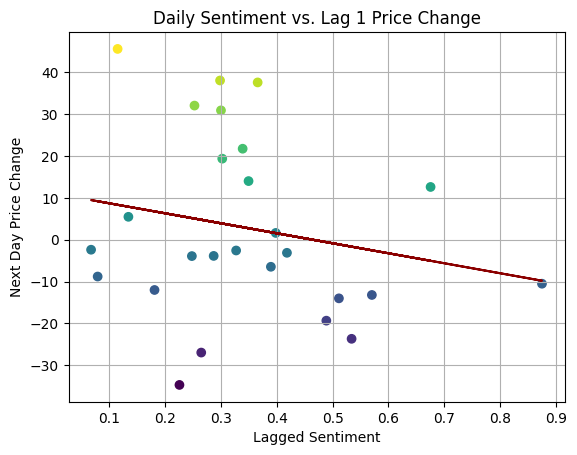

Correlation with 1 Day(s) lag: -0.2
Linear Model R-squared: -0.27
Linear Model RMSE: 28.52

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 532 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


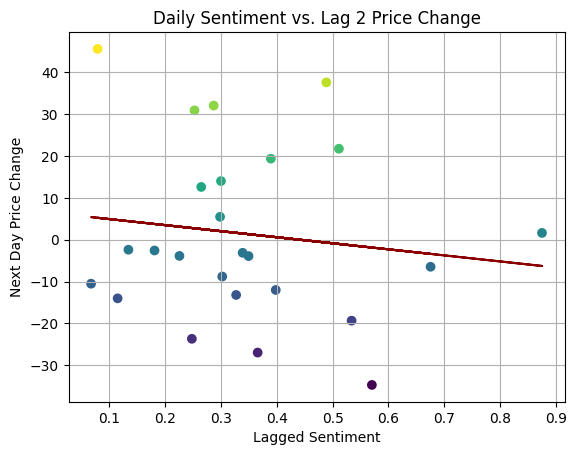

Correlation with 2 Day(s) lag: -0.13
Linear Model R-squared: -0.06
Linear Model RMSE: 21.23

Average Price Change on High Sentiment Days: 153 %
Average Price Change on Low Sentiment Days: 131 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


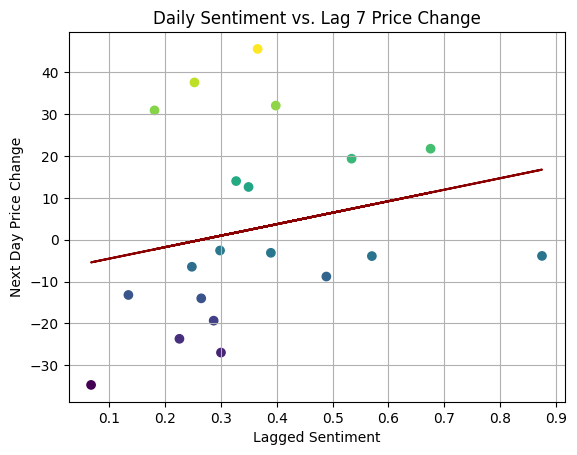

Correlation with 7 Day(s) lag: 0.23
Linear Model R-squared: -6.95
Linear Model RMSE: 19.55

Average Price Change on High Sentiment Days: 312 %
Average Price Change on Low Sentiment Days: 220 %


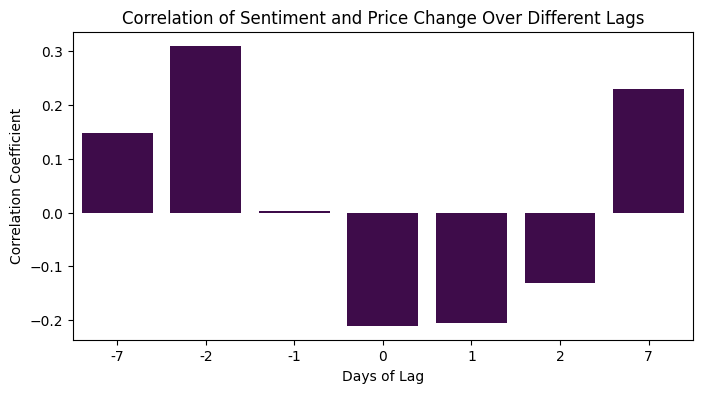

In [109]:
# Get the closing price for each day (last price of the day)
price_data_daily = price_data['normalized price'].resample('D').last()

# Calculate the daily price change percentage
price_data_daily = pd.DataFrame(price_data_daily)  # Ensure it's a DataFrame for the next operations
price_data_daily['Price Change'] = price_data_daily['normalized price'].pct_change() * 100

# Shift the price change to align with the day's sentiment to measure its influence on the next day's price change
price_data_daily['Price Change'] = price_data_daily['Price Change'].shift(-1)

# Since sentiment is often recorded multiple times a day, we'll average it for daily granularity
sentiment_data_daily = pd.DataFrame(sentiment_data['average sentiment'].resample('D').mean())

# Merge the two datasets on the date index
combined_data = pd.concat([price_data_daily, sentiment_data_daily], axis=1)
combined_data.columns = ['Normalized Price', 'Next Day Price Change', 'average sentiment']
combined_data.dropna(inplace=True)  # Drop rows with NaN values that might result from resampling, shifting, or non-overlapping dates
# Perform Analysis
from_date=30
model_type = 'linear'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


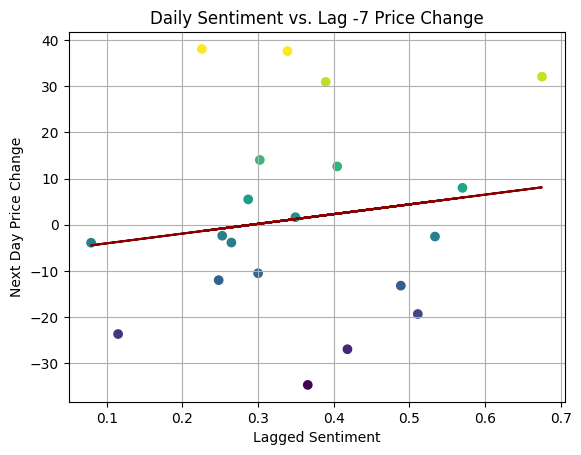

Correlation with -7 Day(s) lag: 0.15
Rf Model R-squared: -0.41
Rf Model RMSE: 30.2

Average Price Change on High Sentiment Days: -580 %
Average Price Change on Low Sentiment Days: 851 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


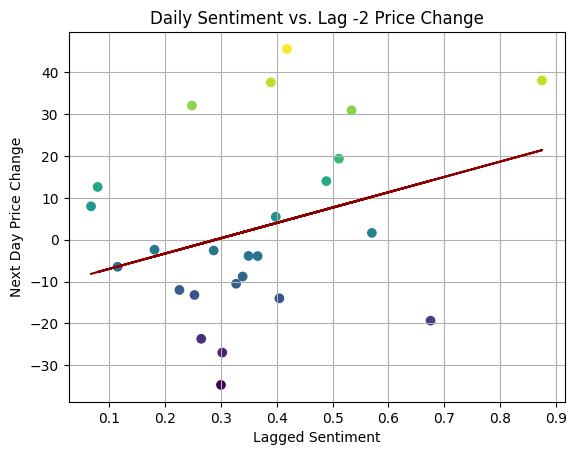

Correlation with -2 Day(s) lag: 0.31
Rf Model R-squared: -0.28
Rf Model RMSE: 30.16

Average Price Change on High Sentiment Days: -220 %
Average Price Change on Low Sentiment Days: 686 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


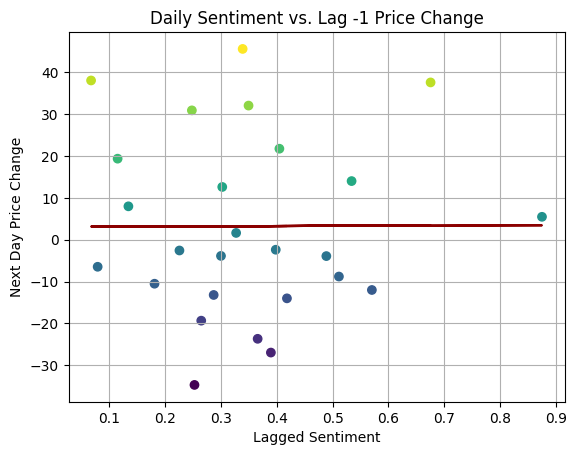

Correlation with -1 Day(s) lag: 0.0
Rf Model R-squared: -0.92
Rf Model RMSE: 29.36

Average Price Change on High Sentiment Days: -35 %
Average Price Change on Low Sentiment Days: 686 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


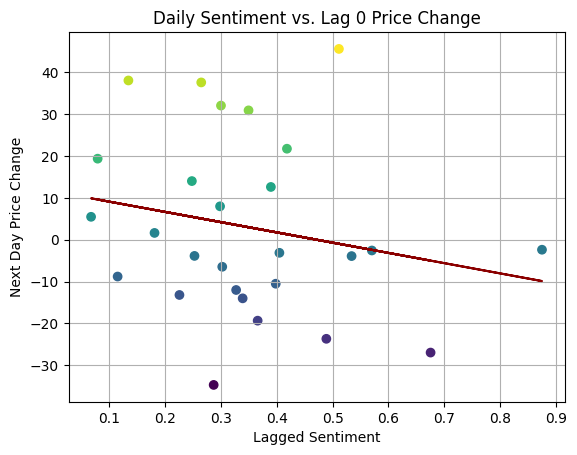

Correlation with 0 Day(s) lag: -0.21
Rf Model R-squared: -0.53
Rf Model RMSE: 27.3

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 551 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


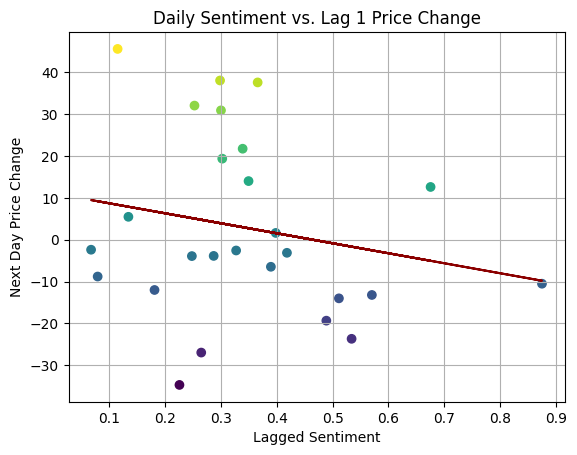

Correlation with 1 Day(s) lag: -0.2
Rf Model R-squared: -0.15
Rf Model RMSE: 27.08

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 532 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


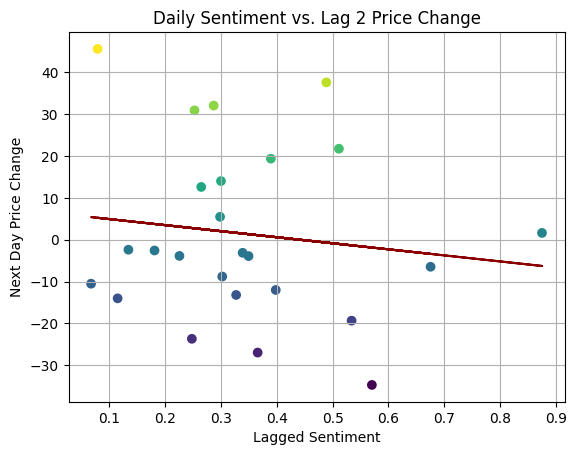

Correlation with 2 Day(s) lag: -0.13
Rf Model R-squared: -0.82
Rf Model RMSE: 27.85

Average Price Change on High Sentiment Days: 153 %
Average Price Change on Low Sentiment Days: 131 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


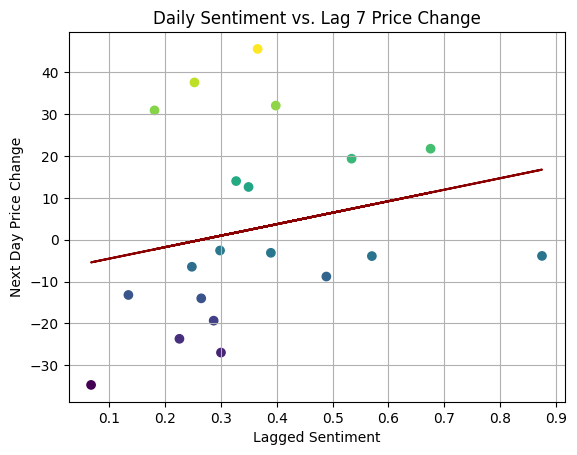

Correlation with 7 Day(s) lag: 0.23
Rf Model R-squared: -14.38
Rf Model RMSE: 27.19

Average Price Change on High Sentiment Days: 312 %
Average Price Change on Low Sentiment Days: 220 %


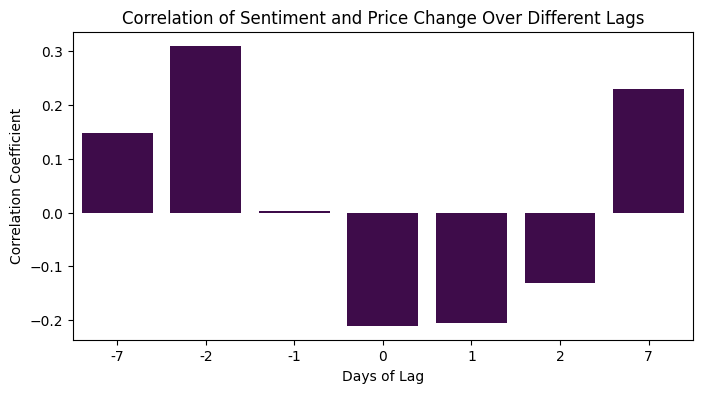

In [110]:
# Perform Analysis
model_type = 'rf'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


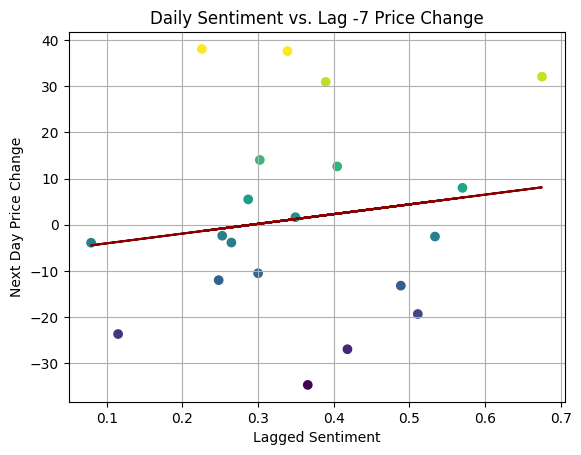

Correlation with -7 Day(s) lag: 0.15
Rf Model R-squared: -0.41
Rf Model RMSE: 30.2

Average Price Change on High Sentiment Days: -580 %
Average Price Change on Low Sentiment Days: 851 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


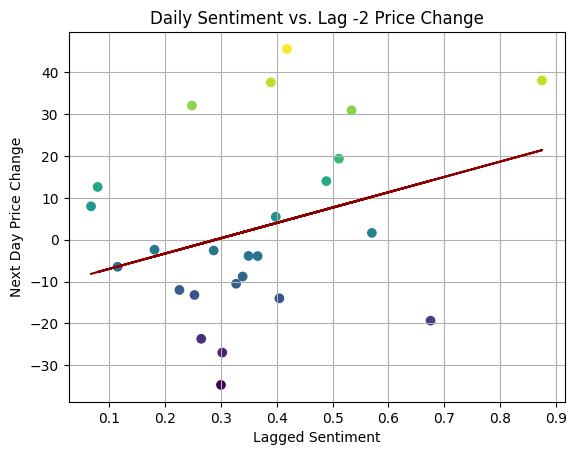

Correlation with -2 Day(s) lag: 0.31
Rf Model R-squared: -0.28
Rf Model RMSE: 30.16

Average Price Change on High Sentiment Days: -220 %
Average Price Change on Low Sentiment Days: 686 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


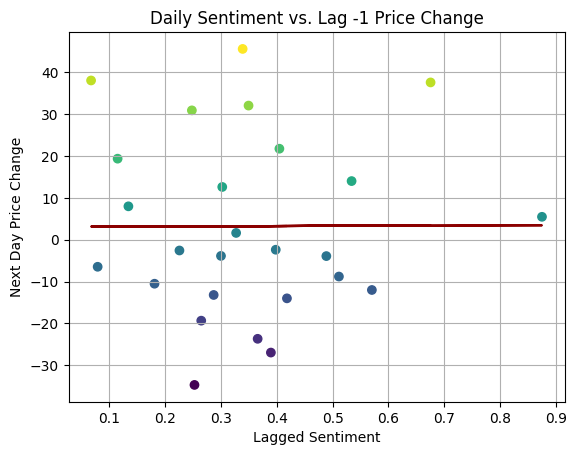

Correlation with -1 Day(s) lag: 0.0
Rf Model R-squared: -0.92
Rf Model RMSE: 29.36

Average Price Change on High Sentiment Days: -35 %
Average Price Change on Low Sentiment Days: 686 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


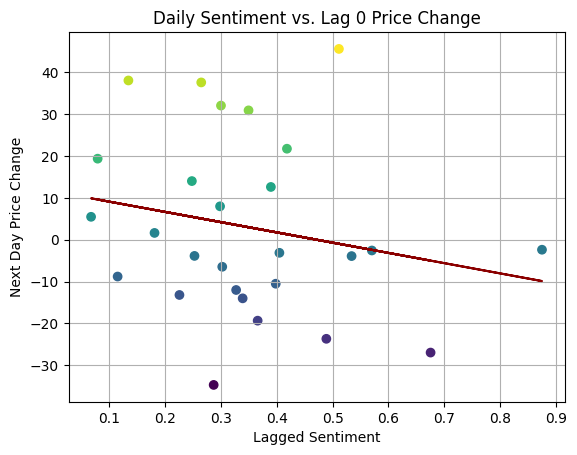

Correlation with 0 Day(s) lag: -0.21
Rf Model R-squared: -0.53
Rf Model RMSE: 27.3

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 551 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


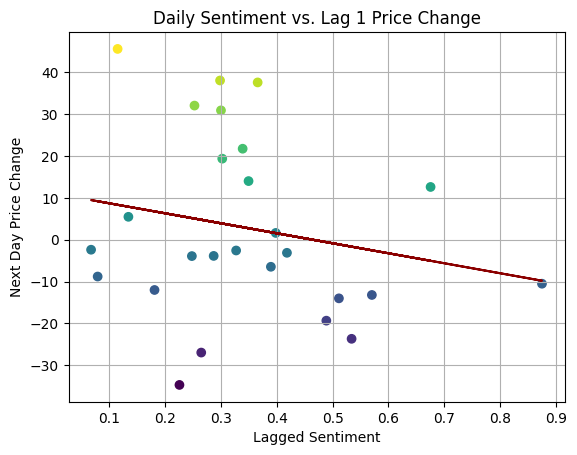

Correlation with 1 Day(s) lag: -0.2
Rf Model R-squared: -0.15
Rf Model RMSE: 27.08

Average Price Change on High Sentiment Days: 33 %
Average Price Change on Low Sentiment Days: 532 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


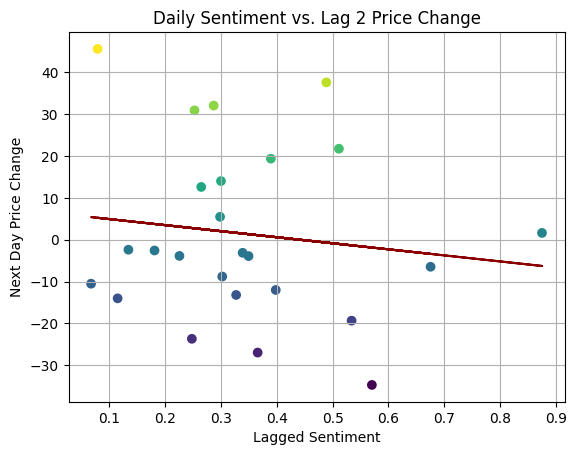

Correlation with 2 Day(s) lag: -0.13
Rf Model R-squared: -0.82
Rf Model RMSE: 27.85

Average Price Change on High Sentiment Days: 153 %
Average Price Change on Low Sentiment Days: 131 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


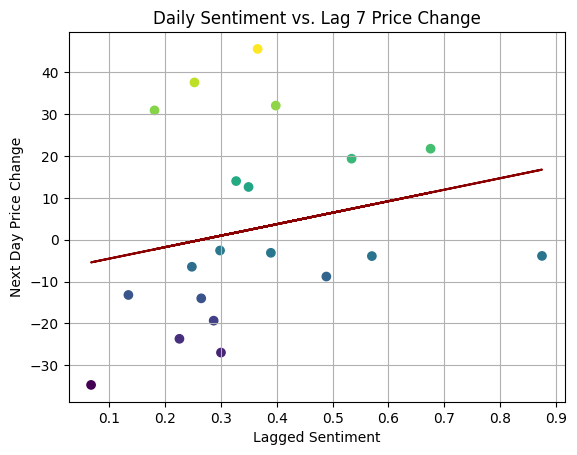

Correlation with 7 Day(s) lag: 0.23
Rf Model R-squared: -14.38
Rf Model RMSE: 27.19

Average Price Change on High Sentiment Days: 312 %
Average Price Change on Low Sentiment Days: 220 %


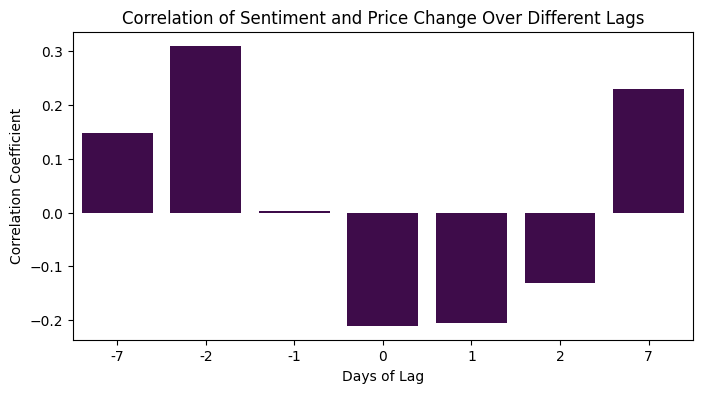

In [111]:
# Perform Analysis
model_type = 'rf'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

# Daily Time Frame APIs Data

2024-05-04 00:00:00 2024-05-06 00:00:00


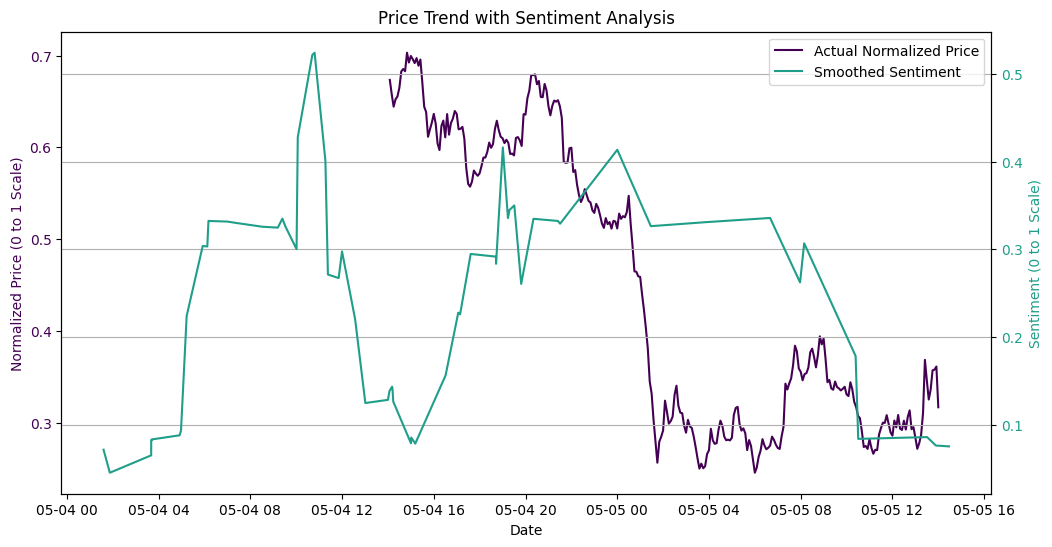

c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


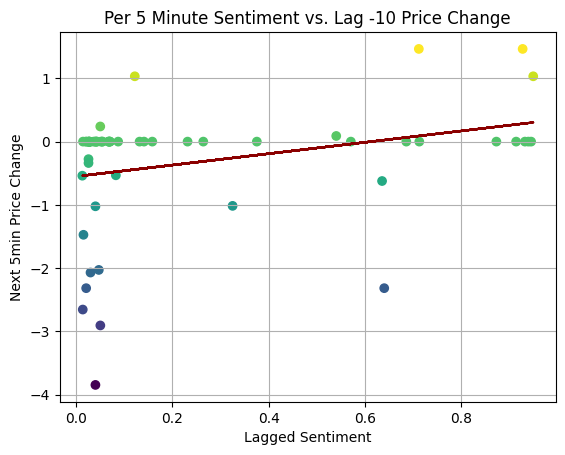

Correlation with -10 5min(s) lag: 0.29
Linear Model R-squared: -0.4
Linear Model RMSE: 0.64

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -18 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


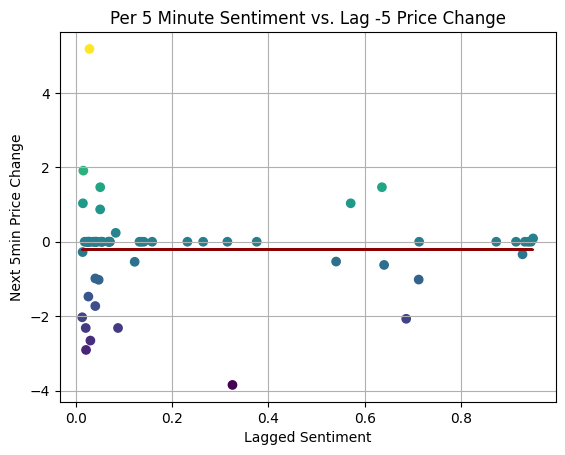

Correlation with -5 5min(s) lag: 0.0
Linear Model R-squared: -0.04
Linear Model RMSE: 1.68

Average Price Change on High Sentiment 5mins: -46 %
Average Price Change on Low Sentiment 5mins: 2 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


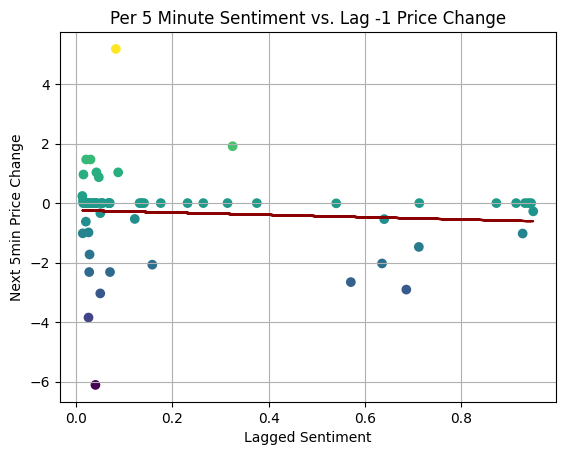

Correlation with -1 5min(s) lag: -0.08
Linear Model R-squared: -0.16
Linear Model RMSE: 1.11

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


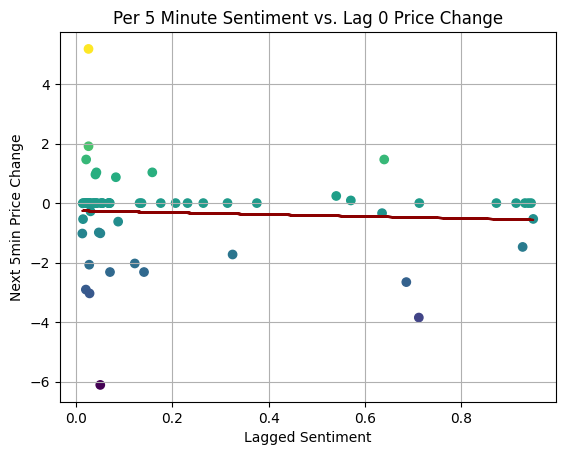

Correlation with 0 5min(s) lag: -0.07
Linear Model R-squared: -0.21
Linear Model RMSE: 1.14

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


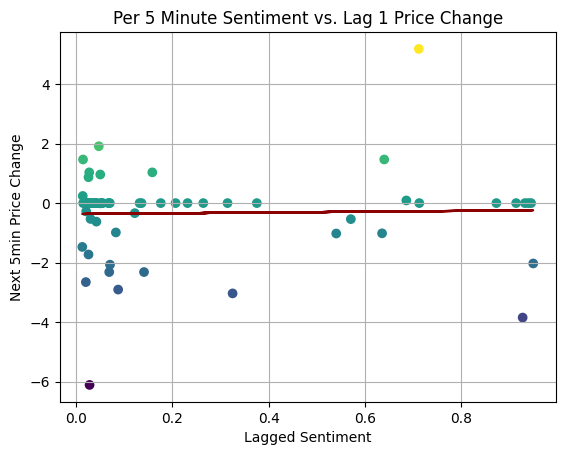

Correlation with 1 5min(s) lag: 0.03
Linear Model R-squared: -0.04
Linear Model RMSE: 1.91

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -23 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


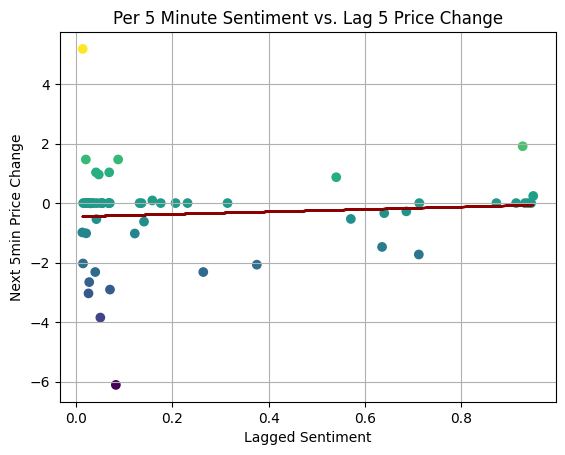

Correlation with 5 5min(s) lag: 0.08
Linear Model R-squared: -0.02
Linear Model RMSE: 1.9

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -25 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:193: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')


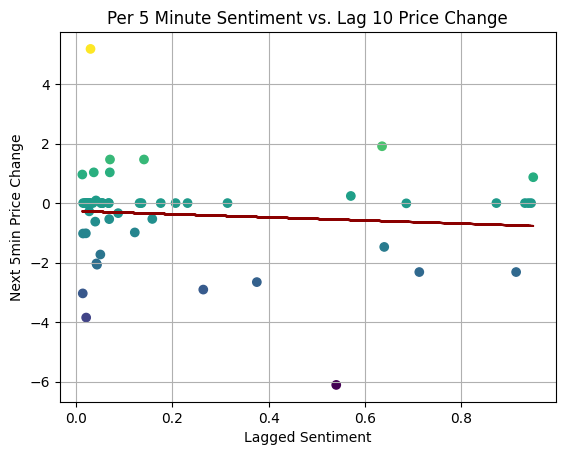

Correlation with 10 5min(s) lag: -0.1
Linear Model R-squared: -0.36
Linear Model RMSE: 1.4

Average Price Change on High Sentiment 5mins: -52 %
Average Price Change on Low Sentiment 5mins: -26 %


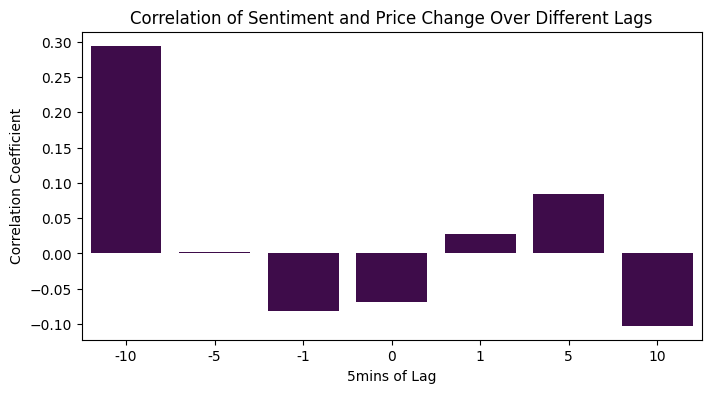

Average Prediction for lag 0: N/A
Average Prediction for lag 1: N/A
Average Prediction for lag 2: -0.41
Average Prediction for lag 3: -0.35
Average Prediction for lag 4: -0.26
Average Prediction for lag 5: N/A
Average Prediction for lag 6: N/A
Overall Average Prediction across all lags: -0.34


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


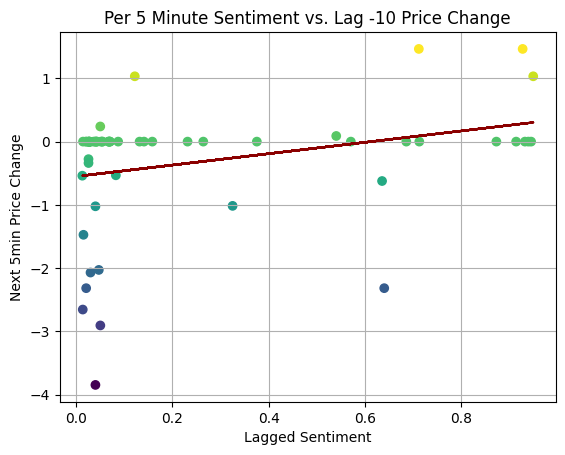

Correlation with -10 5min(s) lag: 0.29
Rf Model R-squared: -1.65
Rf Model RMSE: 0.88

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -18 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


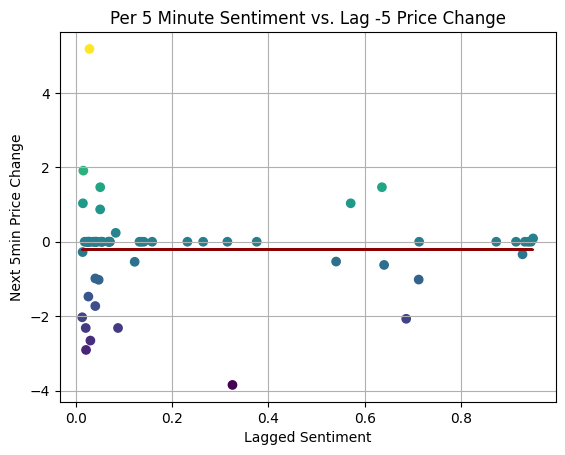

Correlation with -5 5min(s) lag: 0.0
Rf Model R-squared: -0.2
Rf Model RMSE: 1.8

Average Price Change on High Sentiment 5mins: -46 %
Average Price Change on Low Sentiment 5mins: 2 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


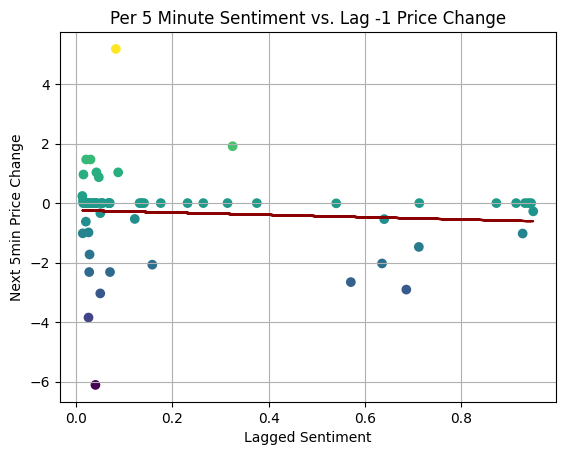

Correlation with -1 5min(s) lag: -0.08
Rf Model R-squared: -0.22
Rf Model RMSE: 1.14

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


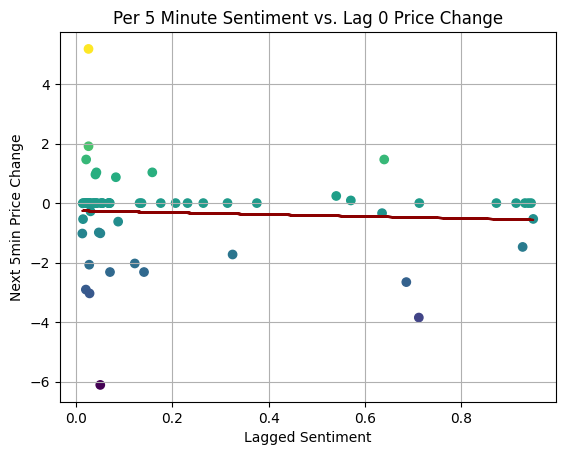

Correlation with 0 5min(s) lag: -0.07
Rf Model R-squared: -0.92
Rf Model RMSE: 1.43

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -22 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


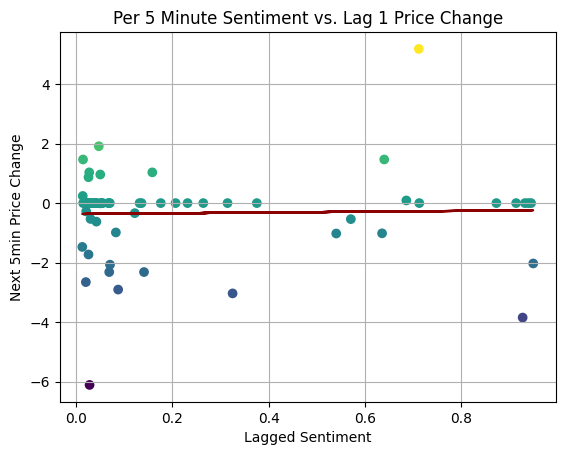

Correlation with 1 5min(s) lag: 0.03
Rf Model R-squared: -0.27
Rf Model RMSE: 2.11

Average Price Change on High Sentiment 5mins: -44 %
Average Price Change on Low Sentiment 5mins: -23 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


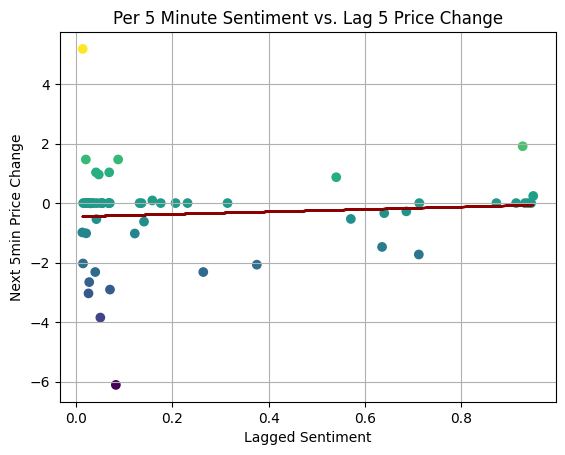

Correlation with 5 5min(s) lag: 0.08
Rf Model R-squared: -0.38
Rf Model RMSE: 2.21

Average Price Change on High Sentiment 5mins: -47 %
Average Price Change on Low Sentiment 5mins: -25 %


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\visualizations.py:202: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_sentiment = combined_data['average sentiment'].tail(predict_days).shift(lag).fillna(method='ffill')
c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


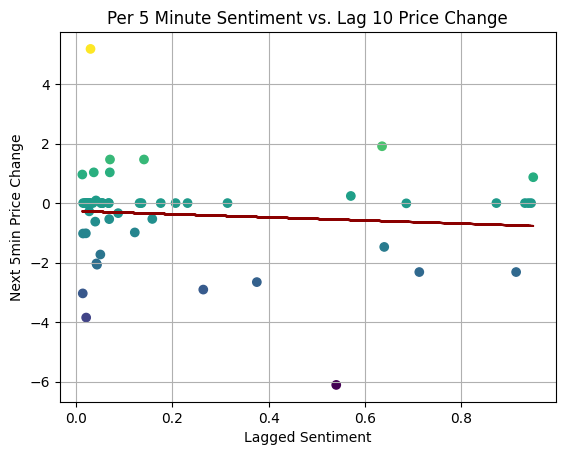

Correlation with 10 5min(s) lag: -0.1
Rf Model R-squared: -1.41
Rf Model RMSE: 1.86

Average Price Change on High Sentiment 5mins: -52 %
Average Price Change on Low Sentiment 5mins: -26 %


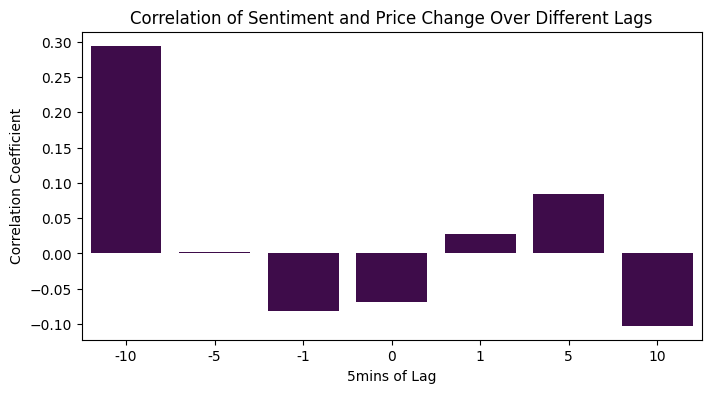

Average Prediction for lag 0: -0.01
Average Prediction for lag 1: -0.02
Average Prediction for lag 2: -2.67
Average Prediction for lag 3: -1.04
Average Prediction for lag 4: -0.74
Average Prediction for lag 5: -0.04
Average Prediction for lag 6: 0.05
Overall Average Prediction across all lags: -0.64


In [142]:
#for testing purposes
sentiment_data = pd.read_csv(f"data/2024-04-05_24h_news_with_sentiment.csv")
price_data = pd.read_csv('data/2024-04-05_24h_50meme_history.csv')
from_date = 0
end = hd.get_date_dt(17.5)
start = hd.get_date_dt(19)
print(start, end)
# Convert the start and end dates to Unix timestamps
start_timestamp = int(pd.Timestamp(start).timestamp())
end_timestamp = int(pd.Timestamp(end).timestamp())
vz.window_size = 7
sentiment_data = vz.average_sentiment_per_time(from_date,sentiment_data, end=end, start=start)
price_data = vz.normalize_and_aggregate_prices(price_data)
plot = vz.plot_normalized_price_and_sentiment(price_data, sentiment_data)

# Calculate percentage price change directly from normalized prices
price_data['price_change'] = price_data['normalized price'].pct_change() * 100
price_data['price_change'] = price_data['price_change'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Resample price data to 5-minute intervals, forward filling the last known prices and changes
price_data_resampled = price_data.resample('5min').last().ffill()

# Round sentiment data timestamps to the nearest 5 minutes
sentiment_data.index = sentiment_data.index.round('5min')

# Merge using merge_asof to align sentiment data with the nearest price data
combined_data = pd.merge_asof(sentiment_data.sort_index(), price_data_resampled.reset_index(), 
                              left_index=True, right_on='timestamp', direction='forward')

# Since we need the next period's price change, shift the 'price_change' column by -1
combined_data['Next 5min Price Change'] = combined_data['price_change'].shift(-1)

# Rename columns to match function expectations
combined_data.rename(columns={'Average Sentiment': 'Average Sentiment'}, inplace=True)

# Drop the 'timestamp' and original 'price_change' columns if not needed
combined_data.drop(columns=['timestamp', 'price_change'], inplace=True)

from_date=1
# Perform Analysis
model_type = 'linear'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")

# Perform Analysis
model_type = 'rf'  # or 'rf'
future_predictions_by_lag = vz.analysis(combined_data, from_date, model_type=model_type, for_web=False, predict_days=5)

# Collect all predictions from each lag
all_predictions = []

# Analyze every prediction of every lag and collect them
for idx, future_predictions in enumerate(future_predictions_by_lag):
    if not isinstance(future_predictions, (list, np.ndarray)):
        future_predictions = [future_predictions]

    # Filter out NaN values
    future_predictions = [pred for pred in future_predictions if not np.isnan(pred)]
    all_predictions.extend(future_predictions)

    avg_prediction = round(np.mean(future_predictions), 2) if future_predictions else 'N/A'
    print(f"Average Prediction for lag {idx}: {avg_prediction}")

# Filter out NaN values from all_predictions
all_predictions = [pred for pred in all_predictions if not np.isnan(pred)]

# Calculate the overall average prediction
overall_avg_prediction = round(np.mean(all_predictions), 2) if all_predictions else 'N/A'
print(f"Overall Average Prediction across all lags: {overall_avg_prediction}")